# import libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

# data pre-processing

* Date: 日期，即交易发生的日期。
* Open: 开盘价，即当天股票交易开始时的价格。
* High: 最高价，即当天股票交易中所达到的最高价格。
* Low: 最低价，即当天股票交易中所达到的最低价格。
* Close: 收盘价，即当天股票交易结束时的价格。
* Adj Close: 调整收盘价，即在除权、除息等情况下对收盘价进行调整后的价格。
* Volume: 成交量，即当天股票交易中的总成交数量。

In [2]:
def main_script(code):

    # 获取对应股票的文件
    def get_fac2_share(code):
        tmp=pd.read_csv('01_data/trade_list/%s.csv'% (code),index_col=0,parse_dates=['date'],dtype={'code': 'str'})
        return tmp

    # import dataset
    seq_len = 20
    fac=get_fac2_share(code)
    fac.drop(columns='code',inplace=True)

    column_indices = fac.columns
    factor_idx=column_indices.drop('target2')
    price_columns = ['open', 'close', 'high', 'low']

    # Plot raw data

    def plot_raw_data(data):
        # transform date format:from str to time
    #     data['Date'] = pd.to_datetime(data['Date'])

        fig, ax = plt.subplots(figsize=(20,10))

        # plot stock history data
        ax.plot(data.index, data['open'], color='b', label='Open')
        ax.plot(data.index, data['high'], color='g', label='High')
        ax.plot(data.index, data['low'], color='m', label='Low')
        ax.plot(data.index, data['close'], color='y', label='Close')

        # format x axis
        ax.xaxis.set_major_locator(mdates.YearLocator()) 
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d')) 

        plt.title('Historical Stock Data %s'%(code), fontsize=26)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.xlabel("date", fontsize = 22)
        plt.ylabel("prices", fontsize = 22)
        plt.grid(True)
        plt.legend(fontsize = 16, bbox_to_anchor=(1, 1))
        plt.savefig('03_output/pic/Historical Stock 4-4 %s.png'%(code))
        plt.show()

    plot_raw_data(fac)

    train_set = fac.loc['2011-01-11':'2023-05-31', factor_idx]

    # feature scaling

    sc1 = MinMaxScaler(feature_range=(0, 1))
    sc2 = MinMaxScaler(feature_range=(0, 1))
    train_set_scaled1 = sc1.fit_transform(train_set[price_columns])
    train_set_scaled2 = sc2.fit_transform(train_set[factor_idx.drop(price_columns)])
    train_set_scaled = np.concatenate((train_set_scaled1,train_set_scaled2),axis=1)
    x_train_set_scaled_df = pd.DataFrame(train_set_scaled, columns=factor_idx)
    x_train_set_scaled_df = x_train_set_scaled_df[price_columns]
    y_train = x_train_set_scaled_df.iloc[seq_len:, 0:4].values

    # function to reshape features into seq_array: (samples, time steps, features)
    def gen_sequence(df, seq_length, seq_cols):
        data_array = df[seq_cols].values
        num_elements = data_array.shape[0]
        for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
            yield data_array[start:stop, :]

    # pick the feature columns
    # sequence_cols = ['open', 'close', 'high', 'low']

    # generator for the training sequences
    x_seq_gen = (list(gen_sequence(x_train_set_scaled_df, seq_len, price_columns)))

    # generate sequences and convert to numpy array
    x_train = np.stack(list(x_seq_gen)).astype(np.float32)

    # define an object (initializing LSTM)
    model = tf.keras.Sequential()

    # first LSTM layer
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=True, input_shape=(seq_len, len(price_columns))))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # second LSTM layer
    model.add(tf.keras.layers.LSTM(units=64, return_sequences=True))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # third LSTM layer
    model.add(tf.keras.layers.LSTM(units=80, return_sequences=True))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # fourth LSTM layer
    model.add(tf.keras.layers.LSTM(units=128))
    # dropout layer
    model.add(tf.keras.layers.Dropout(0.2))
    # output layer
    model.add(tf.keras.layers.Dense(units=4, activation='sigmoid'))

    # compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    model.summary()

    # train the model
    model.fit(x_train, y_train, batch_size=32, epochs=150, validation_split=0.1, verbose=1)

    model.save('02_model/lstm 4-4 %s.h5'%(code))

    # make predictions
    test_data = fac.loc['2023-06-01':'2024-05-29']
    real_stock_price = fac.loc['2023-06-01':'2024-05-29', price_columns]
    # get predicted stock prices of month Dec 2023
    # concatination
    dataset_total = fac.loc[:, factor_idx]

    # stock prices of previous 30 days for each day of Nov 2023
    inputs = dataset_total[len(dataset_total) - len(test_data) - 20:]
    test_set_scaled1 = sc1.fit_transform(inputs[price_columns])
    test_set_scaled2 = sc2.fit_transform(inputs[factor_idx.drop(price_columns)])
    test_set_scaled = np.concatenate((test_set_scaled1,test_set_scaled2),axis=1)
    x_test_set_scaled_df = pd.DataFrame(test_set_scaled, columns=factor_idx)
    x_test_set_scaled_df = x_test_set_scaled_df[price_columns]

    # generator for the training sequences
    x_seq_gen_test = (list(gen_sequence(x_test_set_scaled_df, seq_len, price_columns)))

    # generate sequences and convert to numpy array
    x_test = np.stack(list(x_seq_gen_test)).astype(np.float32)

    # get predicted stock prices
    predicted_stock_price = model.predict(x_test)
    predicted_stock_price = sc1.inverse_transform(predicted_stock_price)
    predicted_stock_price = pd.DataFrame(predicted_stock_price, columns=price_columns)

    predicted_stock_price.index=test_data.index
    predicted_stock_price.to_csv('03_output/csv/pre 4-4 %s.csv'%(code))

    # visualization
    fig = plt.figure(figsize=(20,16))
    # transform date format:from str to time
    # test_data['Date'] = pd.to_datetime(test_data['Date'])
    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(test_data.index, real_stock_price[price_columns[i-1]], color='b', label=price_columns[i-1])
        plt.plot(test_data.index, predicted_stock_price[price_columns[i-1]], color='g', label=price_columns[i-1]+'_predicted')
        plt.title('Predicted Stock Data', fontsize=26)
        plt.xlabel("date", fontsize = 22)
        plt.ylabel("prices", fontsize = 22)
        plt.grid(True)
        plt.legend(fontsize = 16)

    plt.savefig('03_output/pic/predicted 4-4 %s.png'%(code))

    fig = plt.figure(figsize=(20,16))
    # transform date format:from str to time
    # test_data['Date'] = pd.to_datetime(test_data['Date'])
    for i in range(1,5):
        plt.subplot(2,2,i)
        plt.plot(test_data.index, real_stock_price[price_columns[i-1]], color='b', label=price_columns[i-1])
        plt.plot(test_data.index, inputs[20:]['ma2'], color='g', label='ma2')
        plt.title('Predicted Stock Data', fontsize=26)
        plt.xlabel("date", fontsize = 22)
        plt.ylabel("prices", fontsize = 22)
        plt.grid(True)
        plt.legend(fontsize = 16)

    plt.savefig('03_output/pic/ma2 %s.png'%(code))

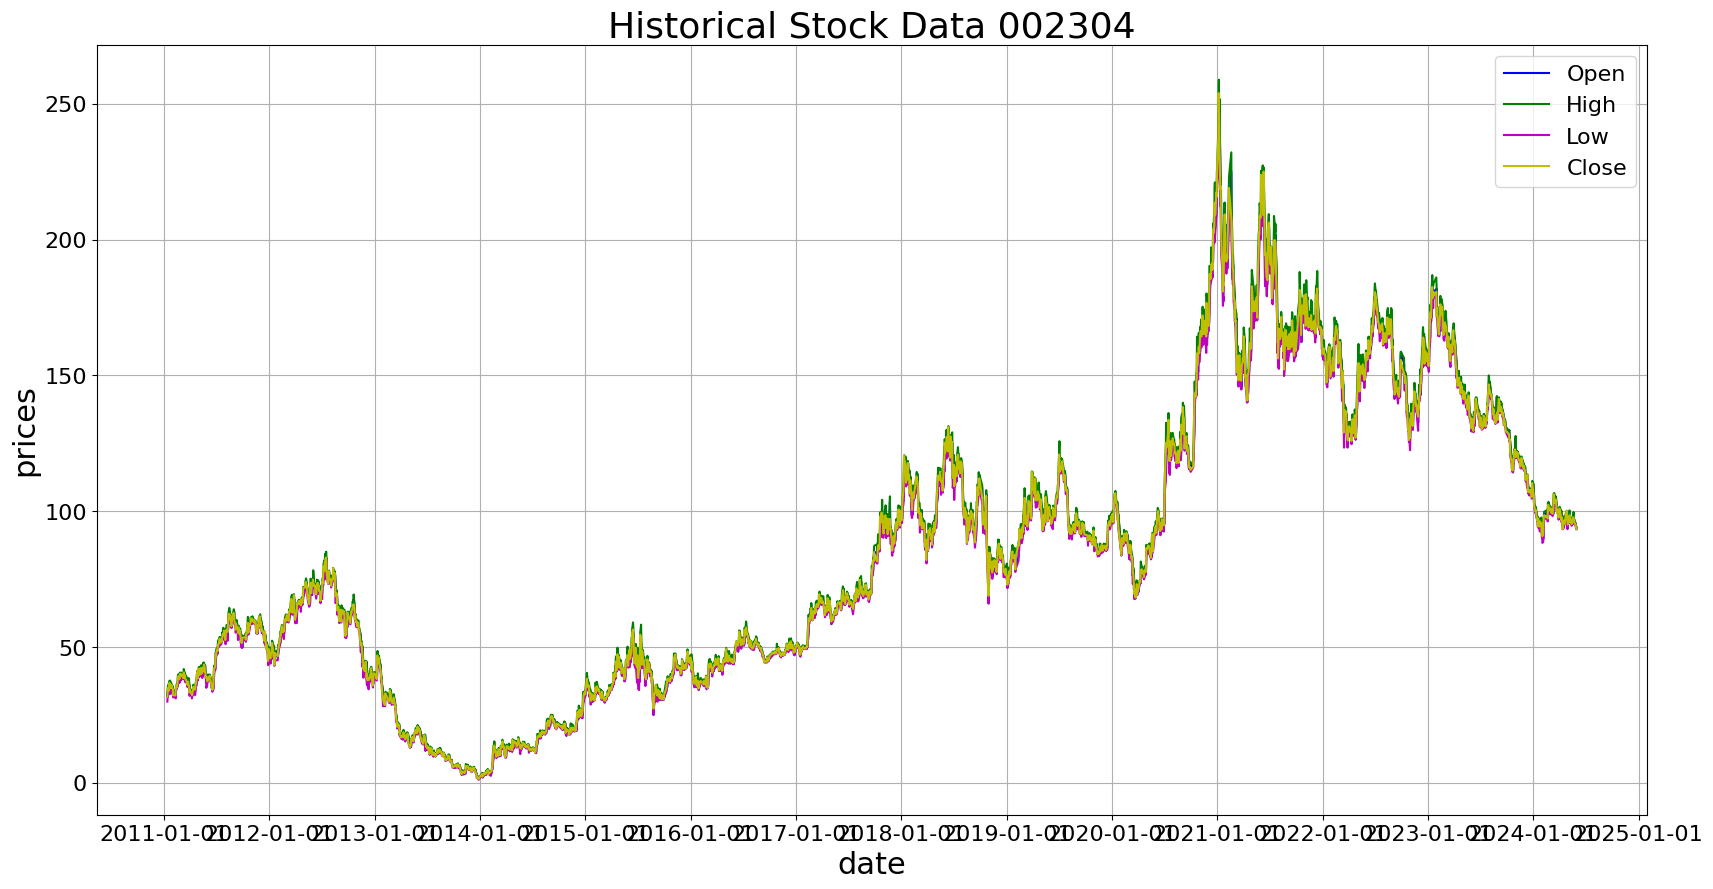

2024-06-06 22:27:30.822252: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:27:30.834712: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:27:30.835238: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:922] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-06 22:27:30.836426: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            17664     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 20, 80)            46400     
                                                                 
 dropout_2 (Dropout)         (None, 20, 80)            0         
                                                                 
 lstm_3 (LSTM)               (None, 128)               1

2024-06-06 22:27:34.757078: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


 1/83 [..............................] - ETA: 5:09 - loss: 0.1054

2024-06-06 22:27:35.504500: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


83/83 [==============================] - 6s 27ms/step - loss: 0.0155 - val_loss: 0.0024
Epoch 2/150
83/83 [==============================] - 1s 17ms/step - loss: 0.0021 - val_loss: 0.0033
Epoch 3/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0021 - val_loss: 0.0025
Epoch 4/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 5/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 6/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0015 - val_loss: 0.0042
Epoch 7/150
83/83 [==============================] - 1s 15ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0013 - val_loss: 0.0016
Epoch 9/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 10/150
83/83 [==============================] - 1s 16ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/15

83/83 [==============================] - 1s 17ms/step - loss: 2.7539e-04 - val_loss: 1.5720e-04
Epoch 78/150
83/83 [==============================] - 1s 17ms/step - loss: 2.7909e-04 - val_loss: 1.5328e-04
Epoch 79/150
83/83 [==============================] - 1s 17ms/step - loss: 2.7220e-04 - val_loss: 8.0211e-04
Epoch 80/150
83/83 [==============================] - 2s 19ms/step - loss: 2.5565e-04 - val_loss: 2.2624e-04
Epoch 81/150
83/83 [==============================] - 1s 18ms/step - loss: 2.9123e-04 - val_loss: 2.2222e-04
Epoch 82/150
83/83 [==============================] - 1s 17ms/step - loss: 2.6271e-04 - val_loss: 1.6369e-04
Epoch 83/150
83/83 [==============================] - 2s 18ms/step - loss: 2.9547e-04 - val_loss: 1.9130e-04
Epoch 84/150
83/83 [==============================] - 1s 17ms/step - loss: 2.6346e-04 - val_loss: 2.5358e-04
Epoch 85/150
83/83 [==============================] - 1s 17ms/step - loss: 3.3827e-04 - val_loss: 4.8901e-04
Epoch 86/150
83/83 [============

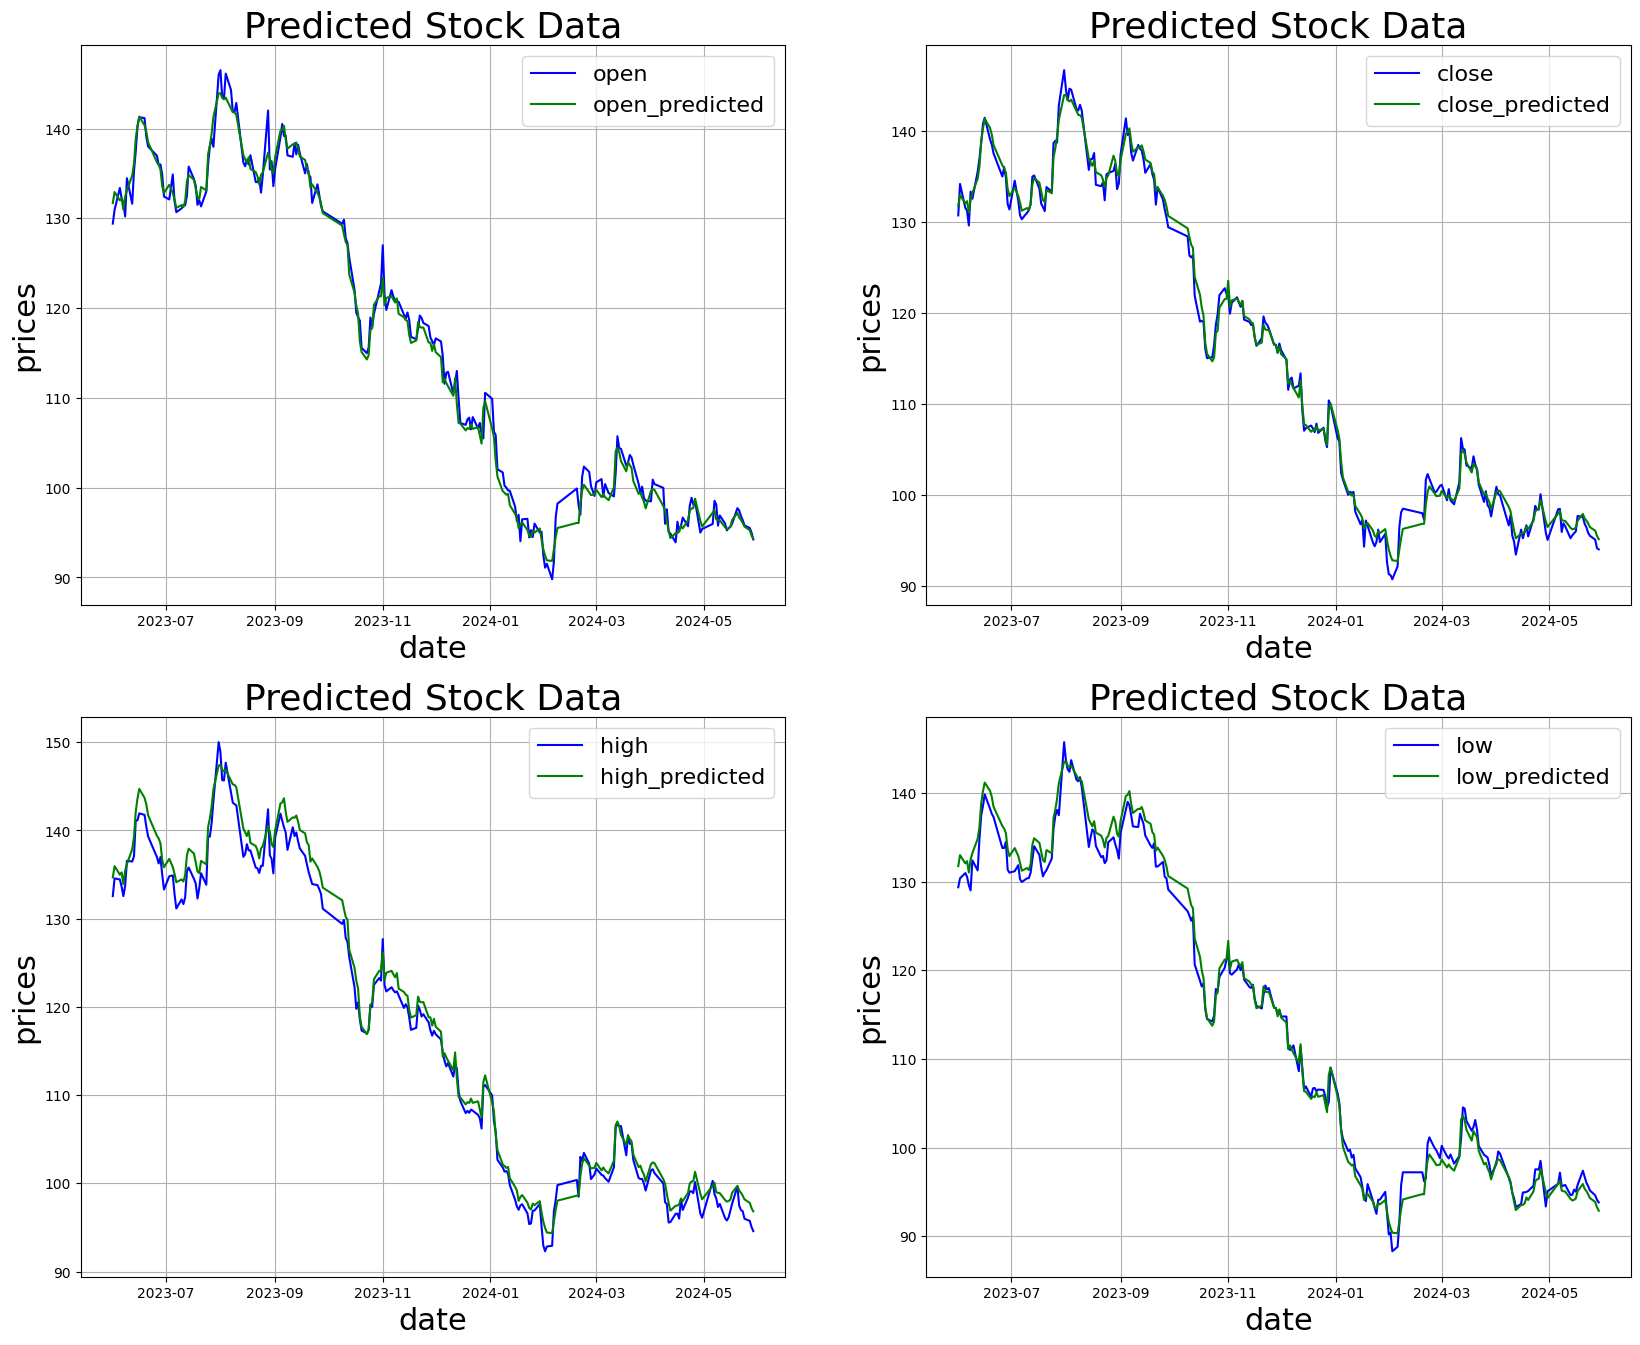

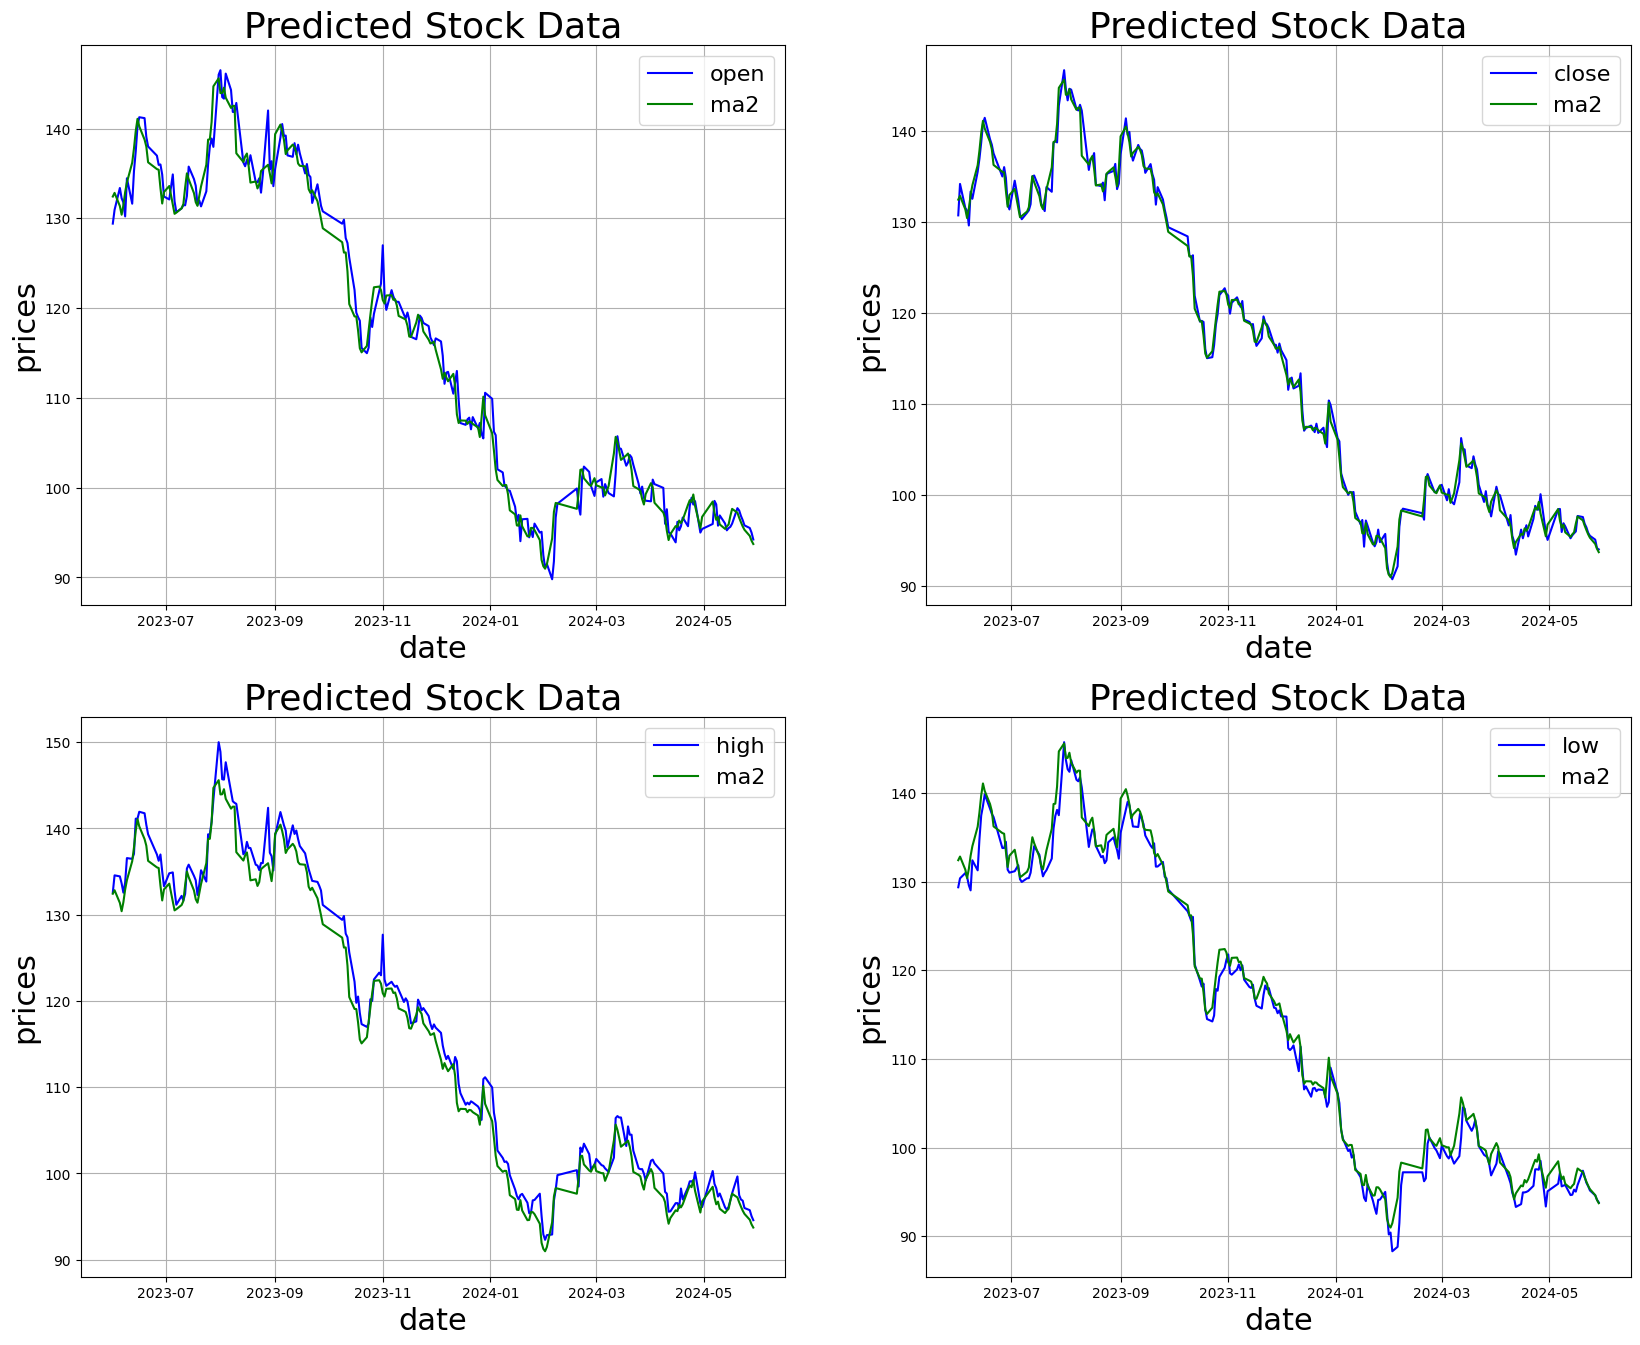

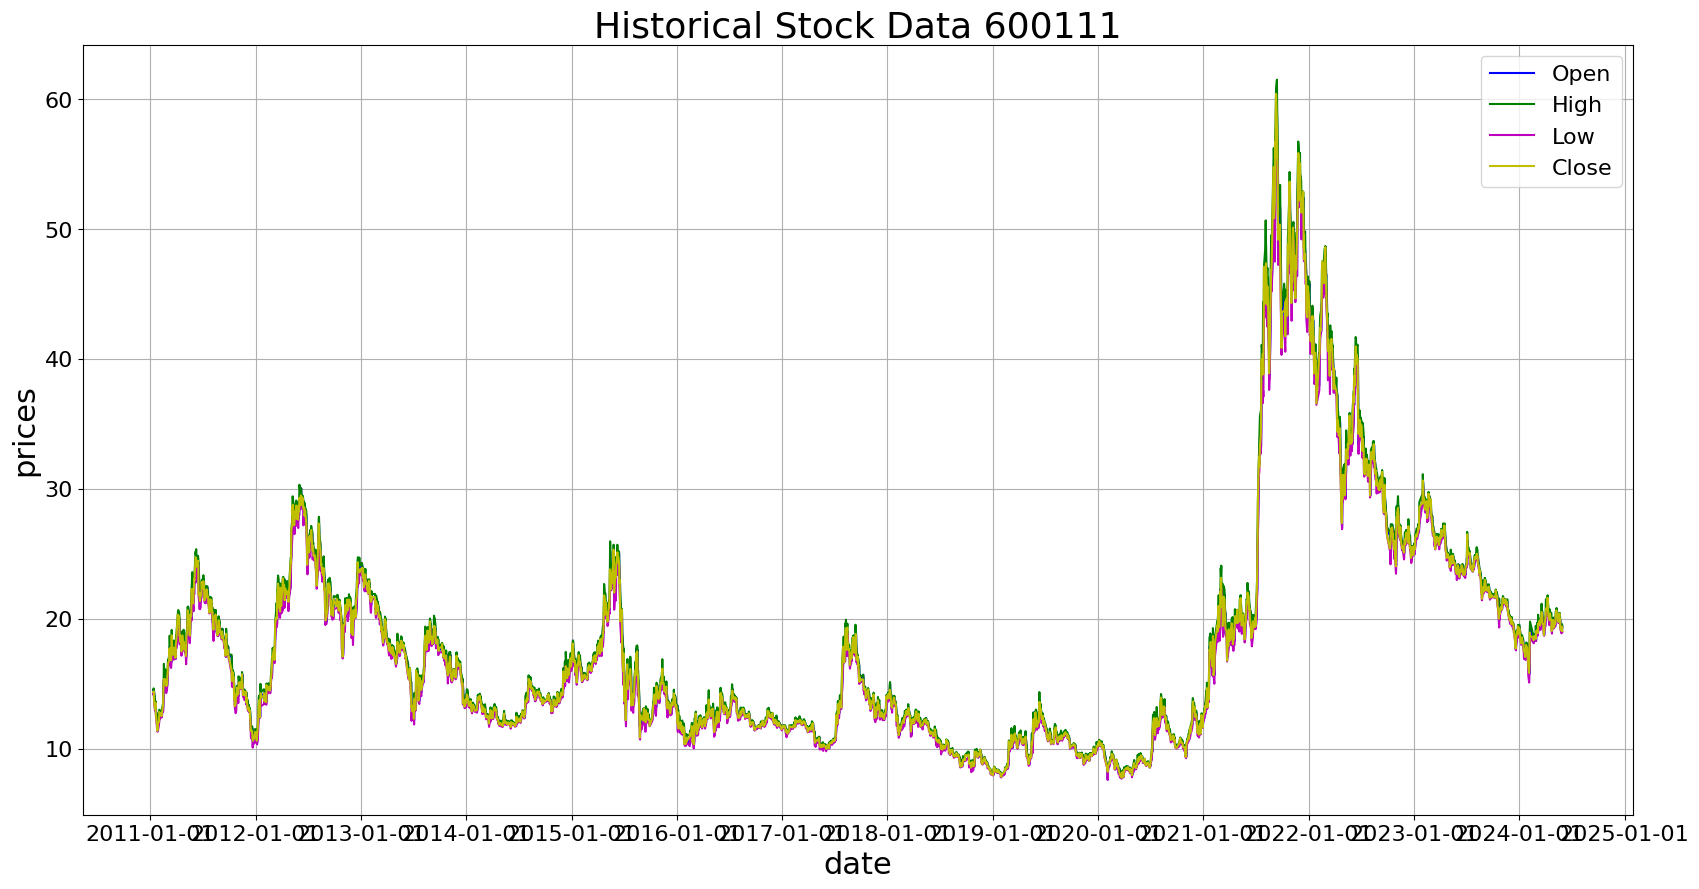

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 20, 64)            17664     
                                                                 
 dropout_4 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_5 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_5 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_6 (LSTM)               (None, 20, 80)            46400     
                                                                 
 dropout_6 (Dropout)         (None, 20, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 128)              

84/84 [==============================] - 2s 18ms/step - loss: 3.3738e-04 - val_loss: 7.3905e-04
Epoch 64/150
84/84 [==============================] - 1s 18ms/step - loss: 3.1186e-04 - val_loss: 4.6862e-04
Epoch 65/150
84/84 [==============================] - 1s 17ms/step - loss: 3.1870e-04 - val_loss: 2.6561e-04
Epoch 66/150
84/84 [==============================] - 1s 18ms/step - loss: 3.1785e-04 - val_loss: 4.9335e-04
Epoch 67/150
84/84 [==============================] - 2s 19ms/step - loss: 2.9269e-04 - val_loss: 0.0011
Epoch 68/150
84/84 [==============================] - 2s 19ms/step - loss: 3.2732e-04 - val_loss: 5.1504e-04
Epoch 69/150
84/84 [==============================] - 1s 17ms/step - loss: 3.2224e-04 - val_loss: 0.0014
Epoch 70/150
84/84 [==============================] - 2s 18ms/step - loss: 3.3097e-04 - val_loss: 8.8706e-04
Epoch 71/150
84/84 [==============================] - 1s 17ms/step - loss: 3.0433e-04 - val_loss: 5.8604e-04
Epoch 72/150
84/84 [====================

84/84 [==============================] - 2s 18ms/step - loss: 2.3211e-04 - val_loss: 3.4601e-04
Epoch 139/150
84/84 [==============================] - 2s 19ms/step - loss: 2.1103e-04 - val_loss: 5.4938e-04
Epoch 140/150
84/84 [==============================] - 1s 17ms/step - loss: 2.2684e-04 - val_loss: 0.0011
Epoch 141/150
84/84 [==============================] - 1s 16ms/step - loss: 2.0929e-04 - val_loss: 3.5226e-04
Epoch 142/150
84/84 [==============================] - 1s 17ms/step - loss: 2.1583e-04 - val_loss: 3.8794e-04
Epoch 143/150
84/84 [==============================] - 1s 17ms/step - loss: 2.2049e-04 - val_loss: 2.8702e-04
Epoch 144/150
84/84 [==============================] - 1s 17ms/step - loss: 2.3521e-04 - val_loss: 6.2056e-04
Epoch 145/150
84/84 [==============================] - 1s 17ms/step - loss: 2.2839e-04 - val_loss: 0.0034
Epoch 146/150
84/84 [==============================] - 1s 16ms/step - loss: 2.6213e-04 - val_loss: 0.0012
Epoch 147/150
84/84 [===============

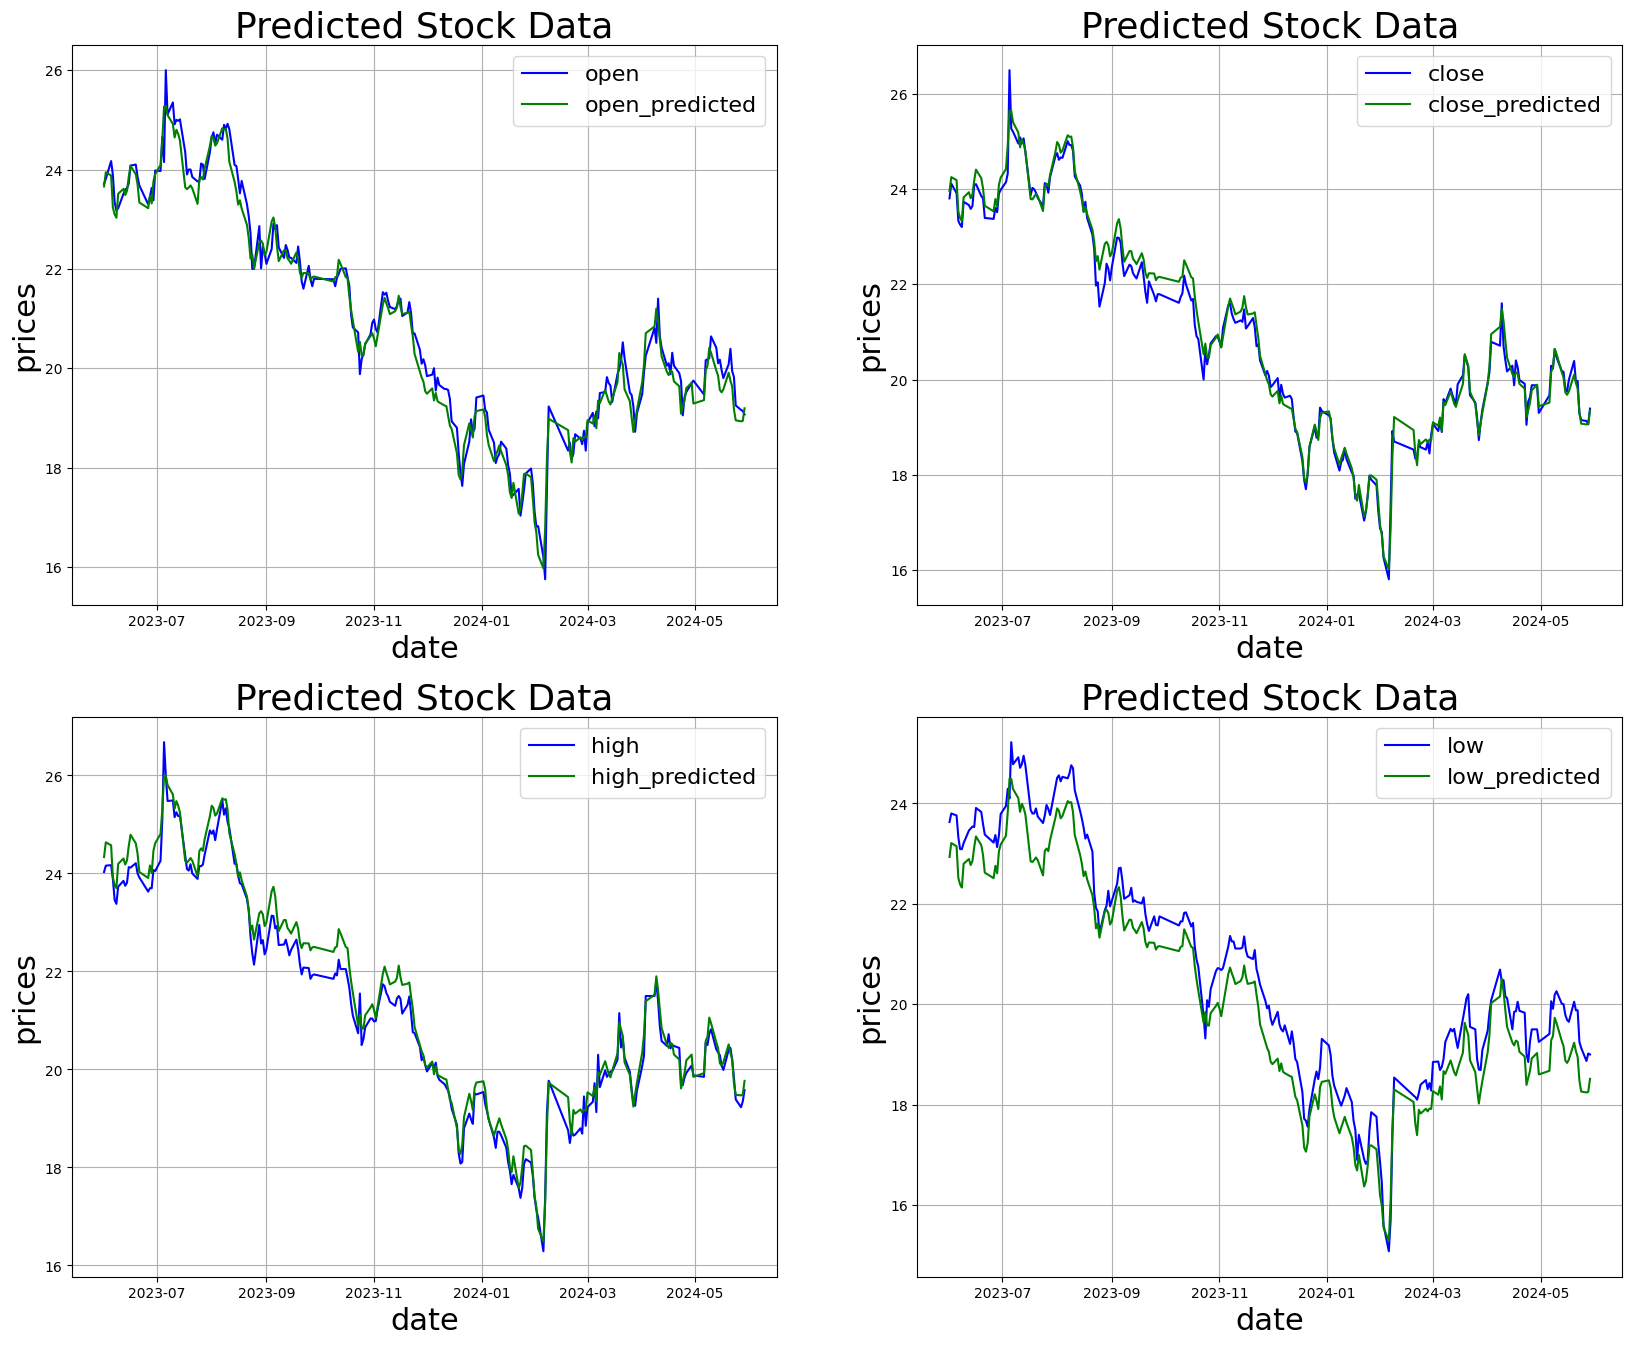

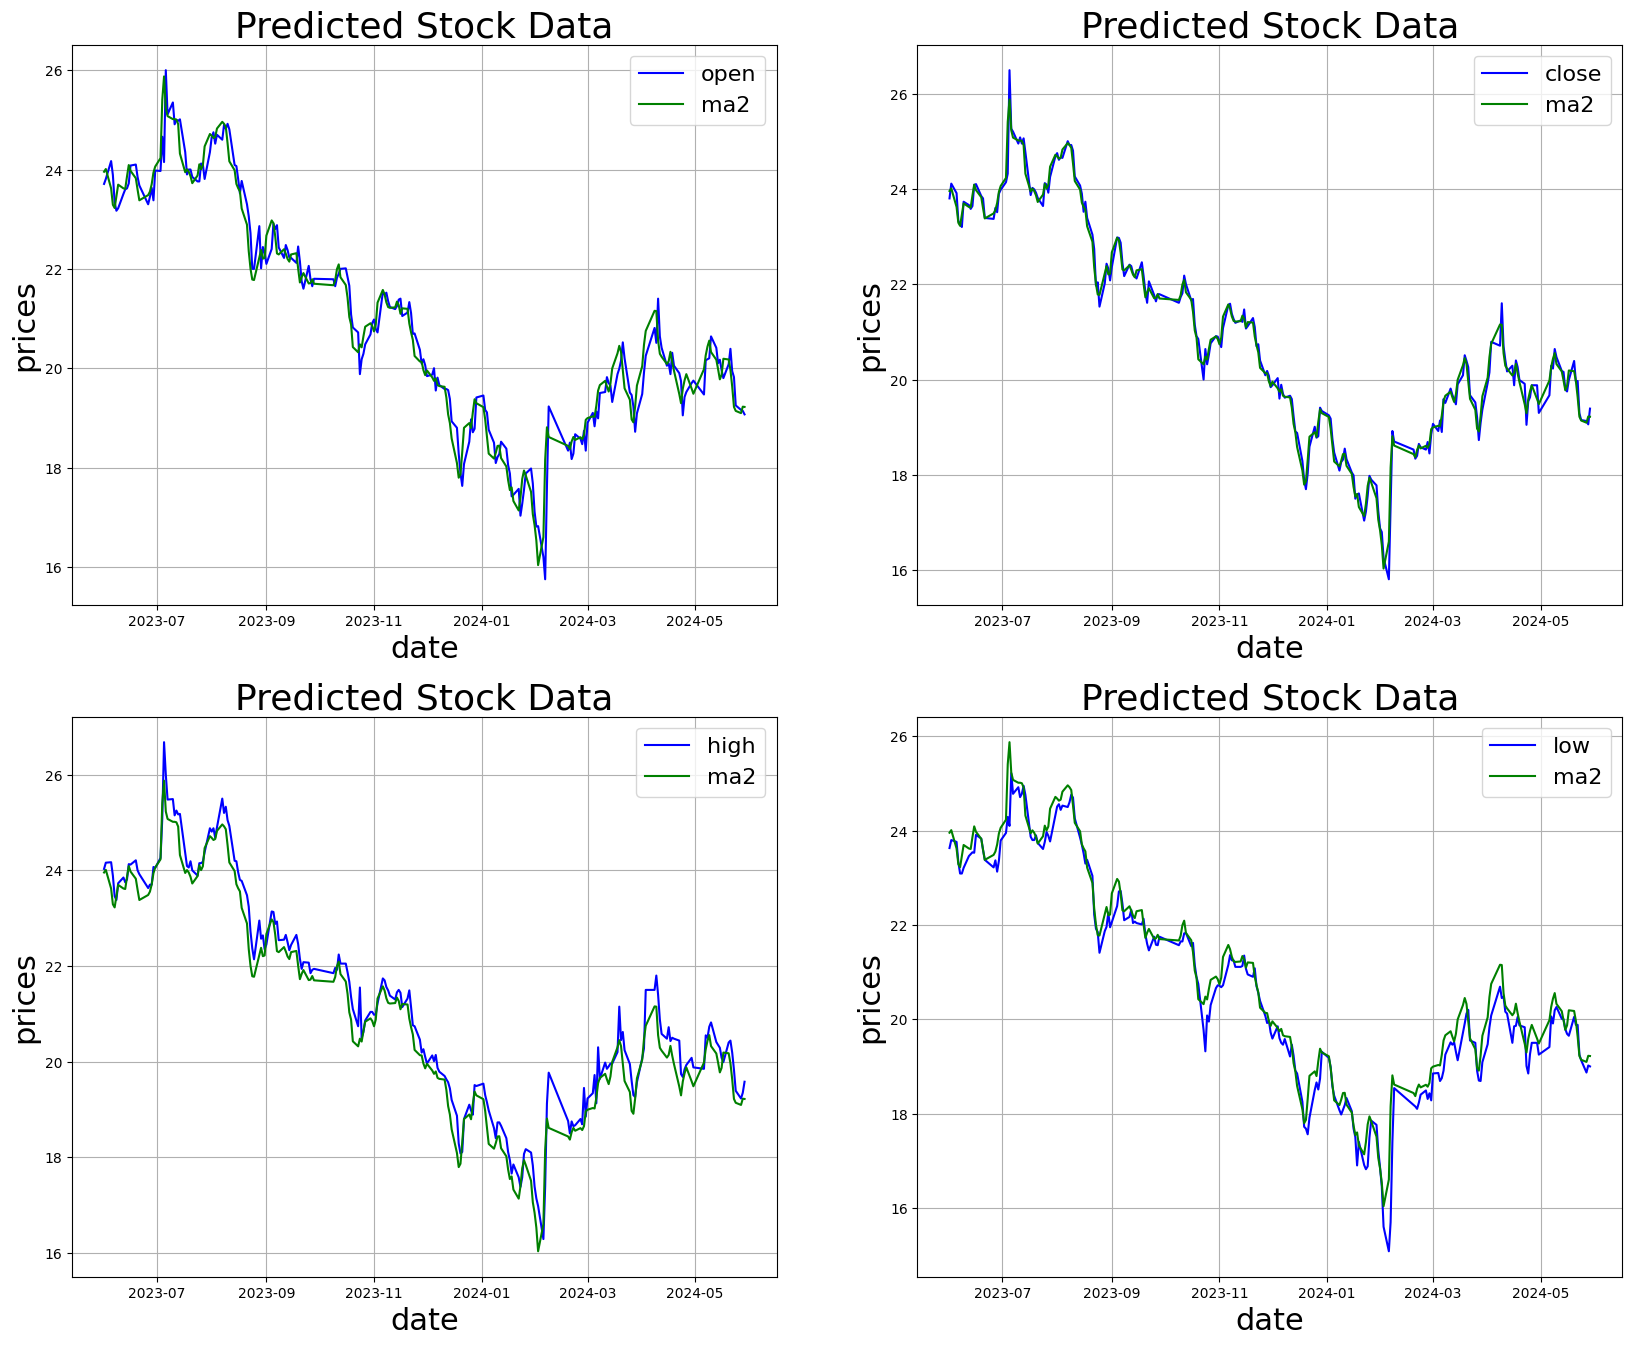

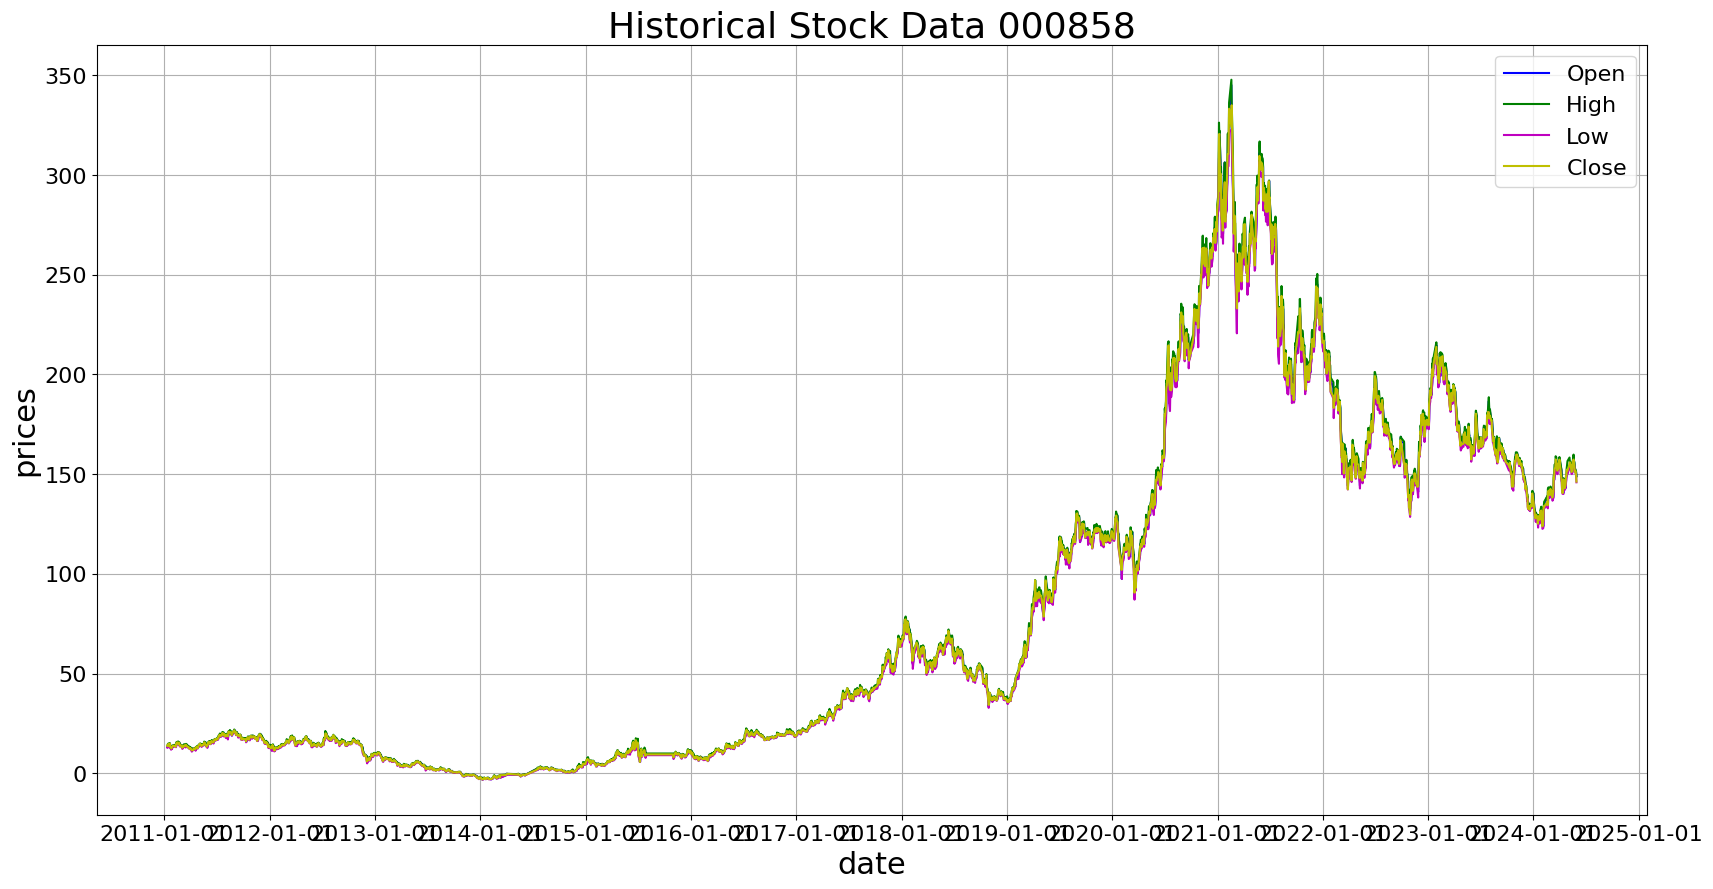

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 20, 64)            17664     
                                                                 
 dropout_8 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_9 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_10 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_10 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_11 (LSTM)              (None, 128)              

81/81 [==============================] - 2s 22ms/step - loss: 3.2223e-04 - val_loss: 1.9920e-04
Epoch 63/150
81/81 [==============================] - 2s 20ms/step - loss: 3.2347e-04 - val_loss: 1.6940e-04
Epoch 64/150
81/81 [==============================] - 2s 19ms/step - loss: 2.8947e-04 - val_loss: 3.2000e-04
Epoch 65/150
81/81 [==============================] - 2s 19ms/step - loss: 3.3363e-04 - val_loss: 4.6432e-04
Epoch 66/150
81/81 [==============================] - 2s 20ms/step - loss: 2.7056e-04 - val_loss: 1.6226e-04
Epoch 67/150
81/81 [==============================] - 2s 20ms/step - loss: 3.1998e-04 - val_loss: 0.0015
Epoch 68/150
81/81 [==============================] - 1s 18ms/step - loss: 3.1859e-04 - val_loss: 2.9061e-04
Epoch 69/150
81/81 [==============================] - 2s 22ms/step - loss: 2.7248e-04 - val_loss: 3.9198e-04
Epoch 70/150
81/81 [==============================] - 1s 18ms/step - loss: 2.7150e-04 - val_loss: 2.4029e-04
Epoch 71/150
81/81 [================

Epoch 137/150
81/81 [==============================] - 1s 17ms/step - loss: 1.8507e-04 - val_loss: 9.1234e-05
Epoch 138/150
81/81 [==============================] - 1s 18ms/step - loss: 1.8951e-04 - val_loss: 8.7226e-05
Epoch 139/150
81/81 [==============================] - 2s 20ms/step - loss: 2.3833e-04 - val_loss: 8.4513e-05
Epoch 140/150
81/81 [==============================] - 1s 18ms/step - loss: 1.8993e-04 - val_loss: 1.1534e-04
Epoch 141/150
81/81 [==============================] - 1s 18ms/step - loss: 2.1722e-04 - val_loss: 1.1875e-04
Epoch 142/150
81/81 [==============================] - 2s 19ms/step - loss: 2.2101e-04 - val_loss: 7.9382e-05
Epoch 143/150
81/81 [==============================] - 1s 18ms/step - loss: 1.8122e-04 - val_loss: 1.5440e-04
Epoch 144/150
81/81 [==============================] - 1s 18ms/step - loss: 1.8028e-04 - val_loss: 1.1581e-04
Epoch 145/150
81/81 [==============================] - 1s 18ms/step - loss: 2.0415e-04 - val_loss: 9.4903e-05
Epoch 146/

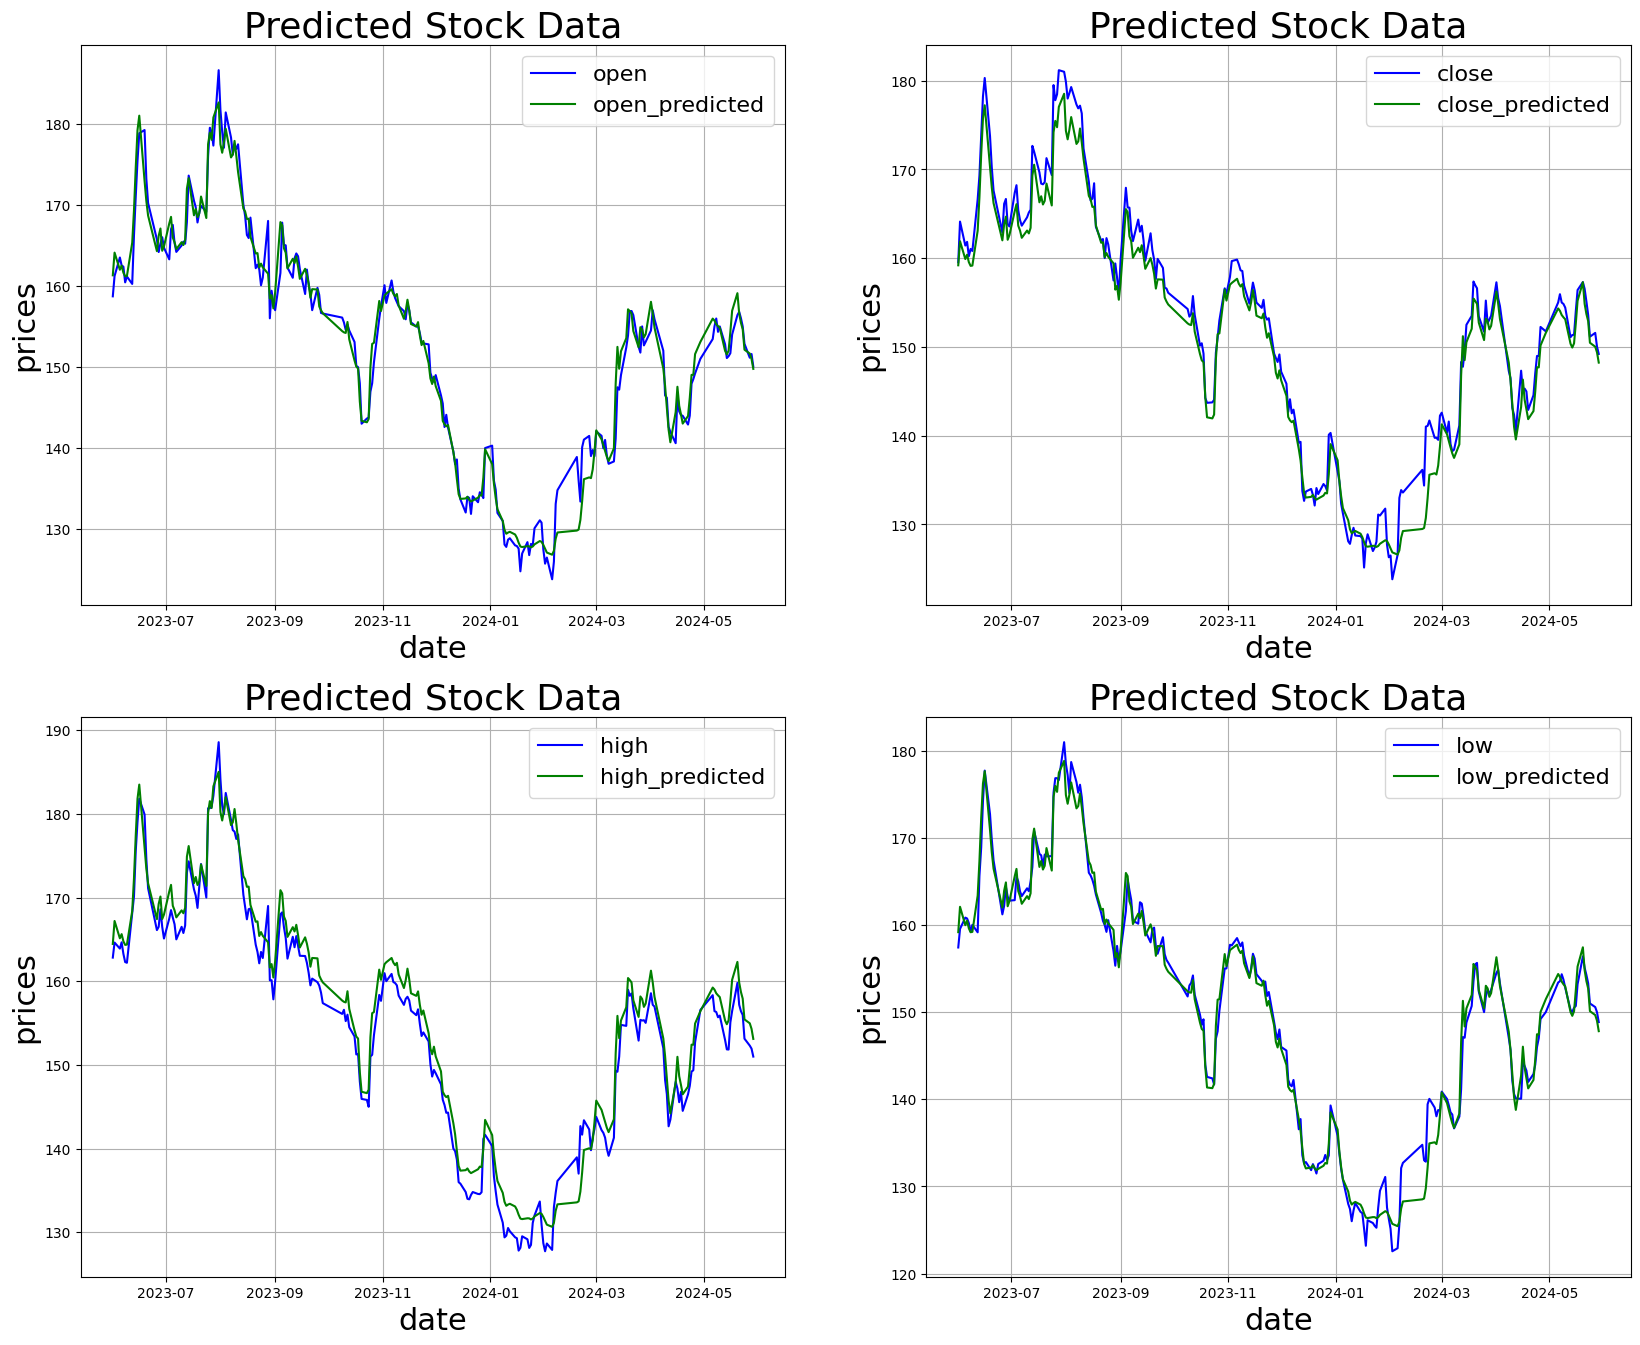

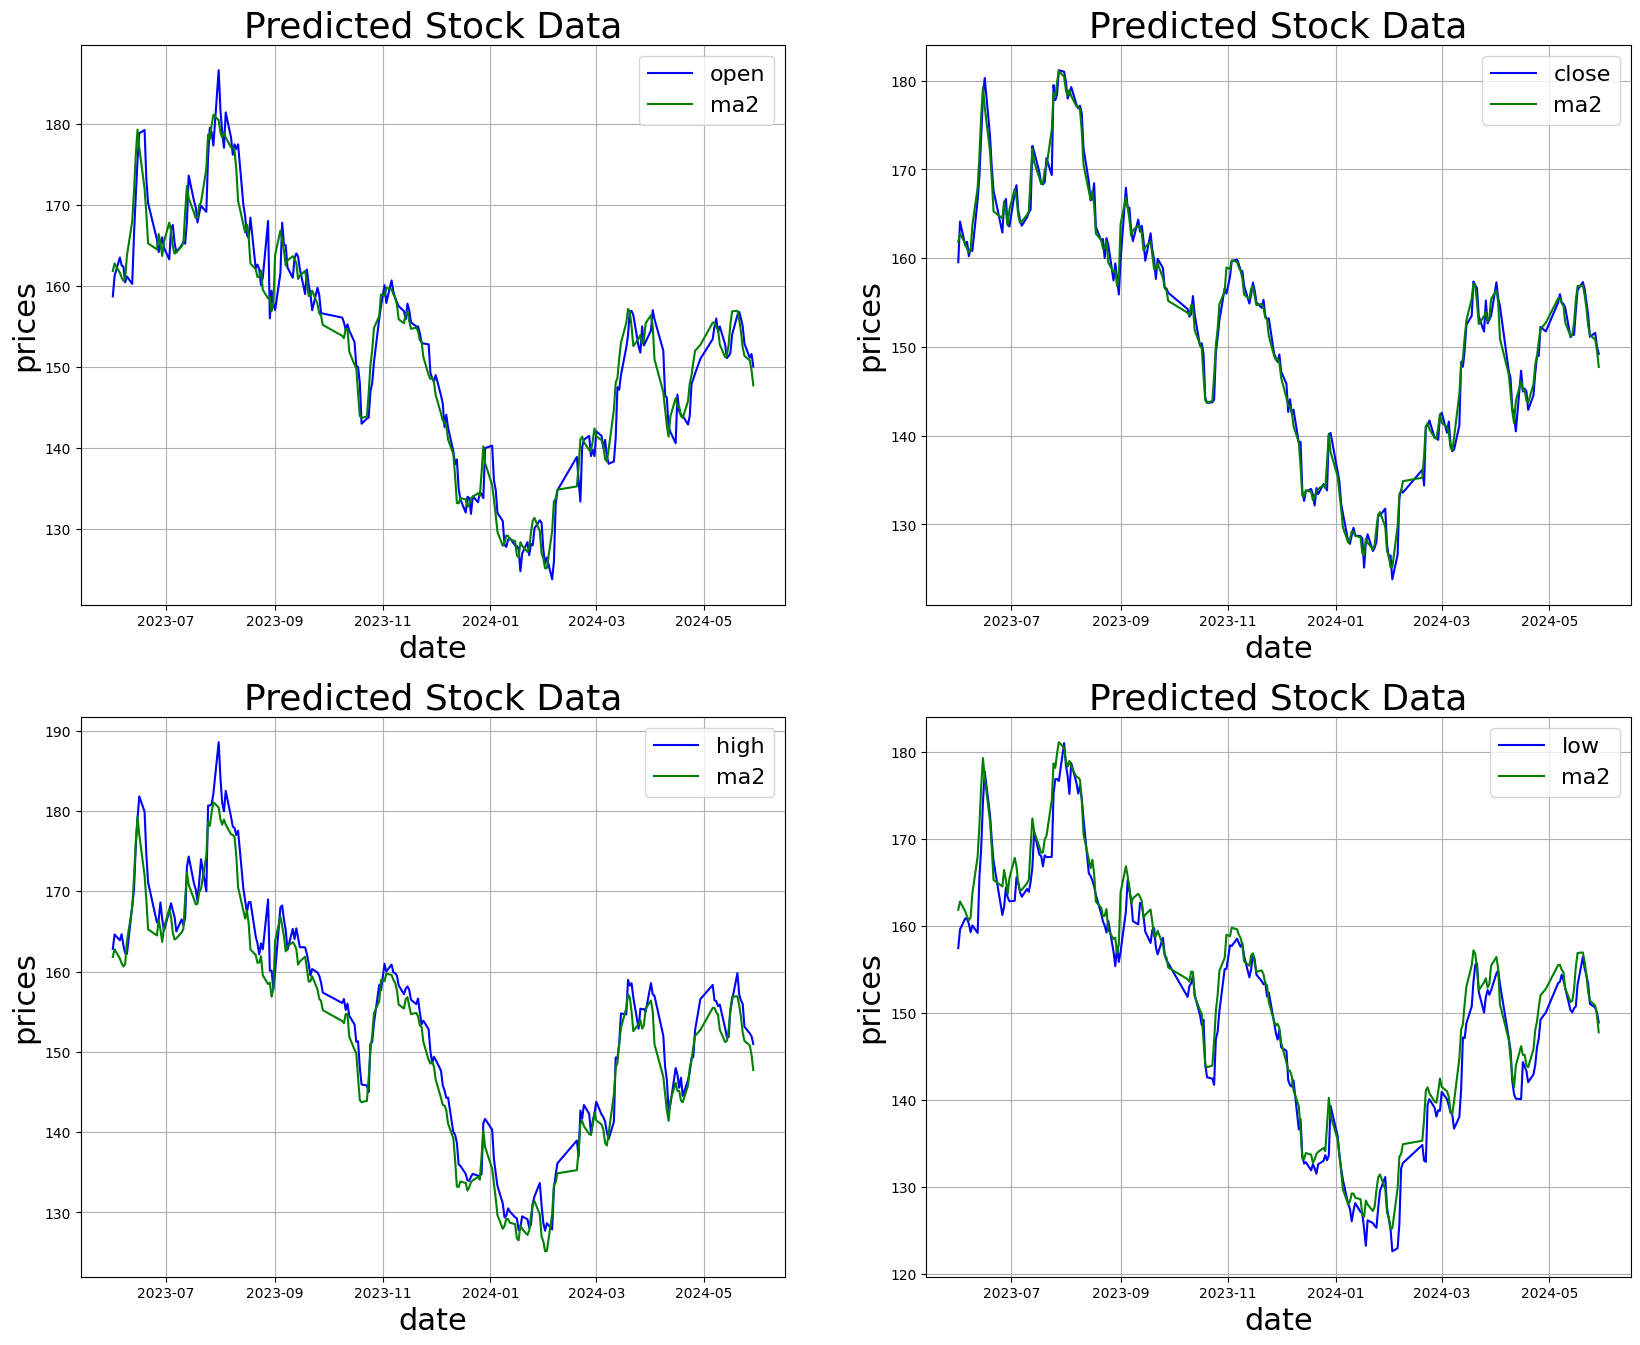

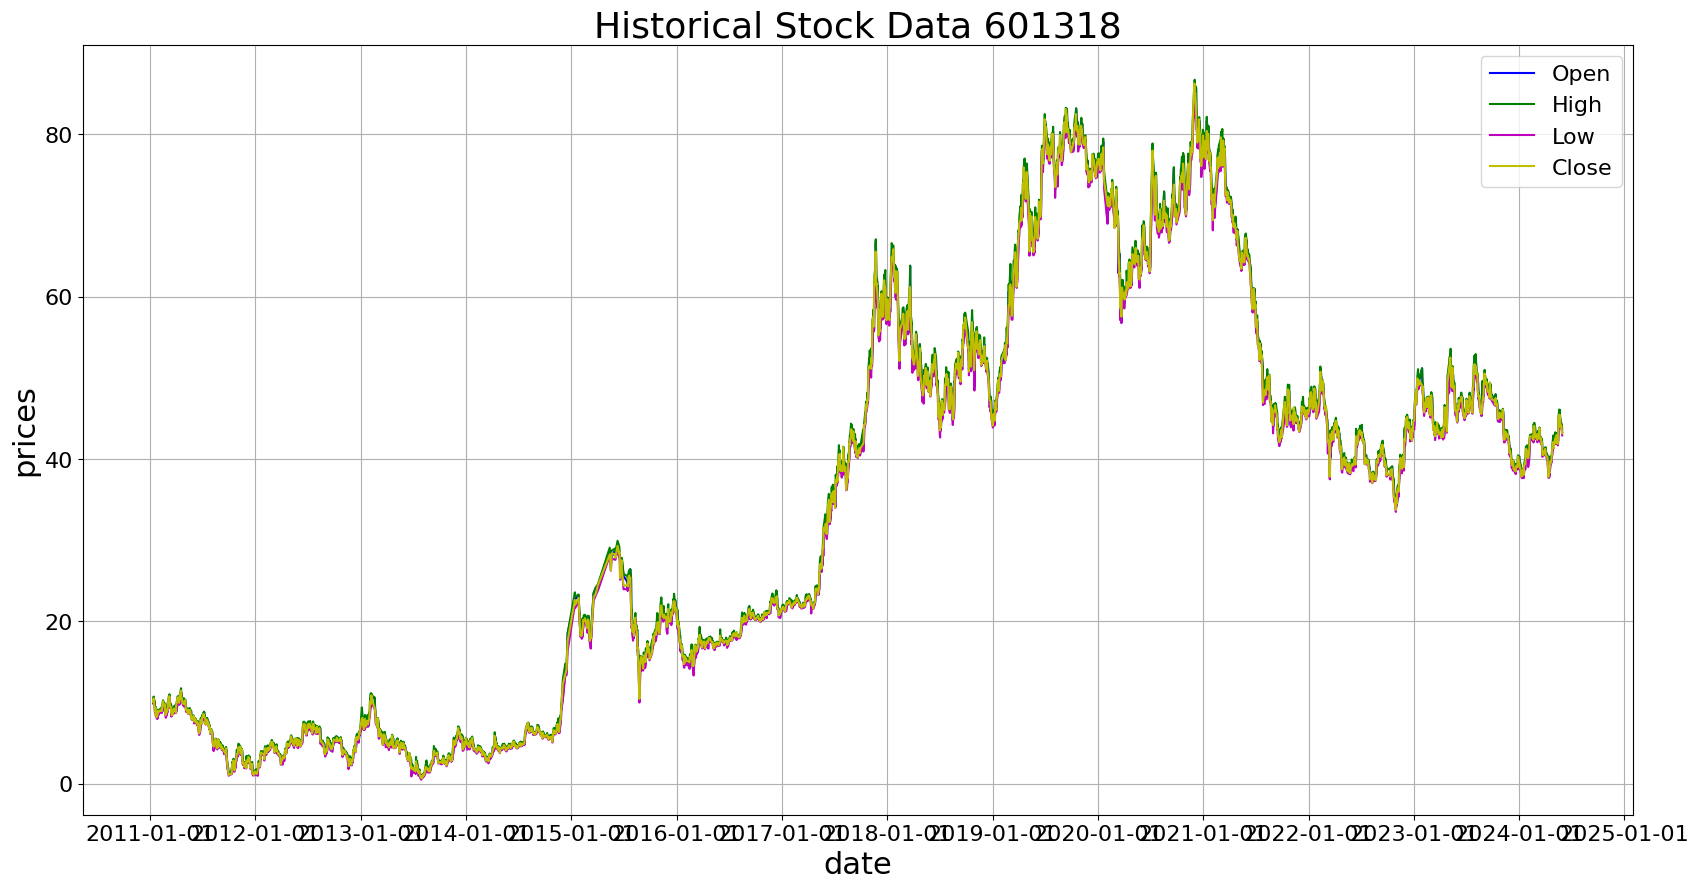

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20, 64)            17664     
                                                                 
 dropout_12 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_13 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_13 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_14 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_14 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_15 (LSTM)              (None, 128)              

81/81 [==============================] - 1s 17ms/step - loss: 3.6229e-04 - val_loss: 1.1950e-04
Epoch 63/150
81/81 [==============================] - 1s 18ms/step - loss: 3.7504e-04 - val_loss: 3.3298e-04
Epoch 64/150
81/81 [==============================] - 1s 17ms/step - loss: 4.0224e-04 - val_loss: 1.4373e-04
Epoch 65/150
81/81 [==============================] - 1s 17ms/step - loss: 3.3669e-04 - val_loss: 3.3385e-04
Epoch 66/150
81/81 [==============================] - 1s 17ms/step - loss: 4.1035e-04 - val_loss: 8.7681e-05
Epoch 67/150
81/81 [==============================] - 1s 16ms/step - loss: 3.4549e-04 - val_loss: 9.1694e-05
Epoch 68/150
81/81 [==============================] - 1s 17ms/step - loss: 3.4103e-04 - val_loss: 9.3321e-05
Epoch 69/150
81/81 [==============================] - 1s 16ms/step - loss: 3.2556e-04 - val_loss: 8.4266e-05
Epoch 70/150
81/81 [==============================] - 1s 16ms/step - loss: 3.2789e-04 - val_loss: 7.9164e-05
Epoch 71/150
81/81 [============

Epoch 137/150
81/81 [==============================] - 1s 17ms/step - loss: 2.6639e-04 - val_loss: 1.5638e-04
Epoch 138/150
81/81 [==============================] - 1s 17ms/step - loss: 2.9543e-04 - val_loss: 1.3781e-04
Epoch 139/150
81/81 [==============================] - 1s 17ms/step - loss: 2.4083e-04 - val_loss: 7.1909e-05
Epoch 140/150
81/81 [==============================] - 1s 16ms/step - loss: 2.7585e-04 - val_loss: 1.0584e-04
Epoch 141/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3125e-04 - val_loss: 1.4656e-04
Epoch 142/150
81/81 [==============================] - 1s 16ms/step - loss: 2.4801e-04 - val_loss: 2.2175e-04
Epoch 143/150
81/81 [==============================] - 1s 16ms/step - loss: 2.4701e-04 - val_loss: 7.0978e-05
Epoch 144/150
81/81 [==============================] - 1s 17ms/step - loss: 2.5264e-04 - val_loss: 2.3701e-04
Epoch 145/150
81/81 [==============================] - 1s 17ms/step - loss: 2.6737e-04 - val_loss: 2.0394e-04
Epoch 146/

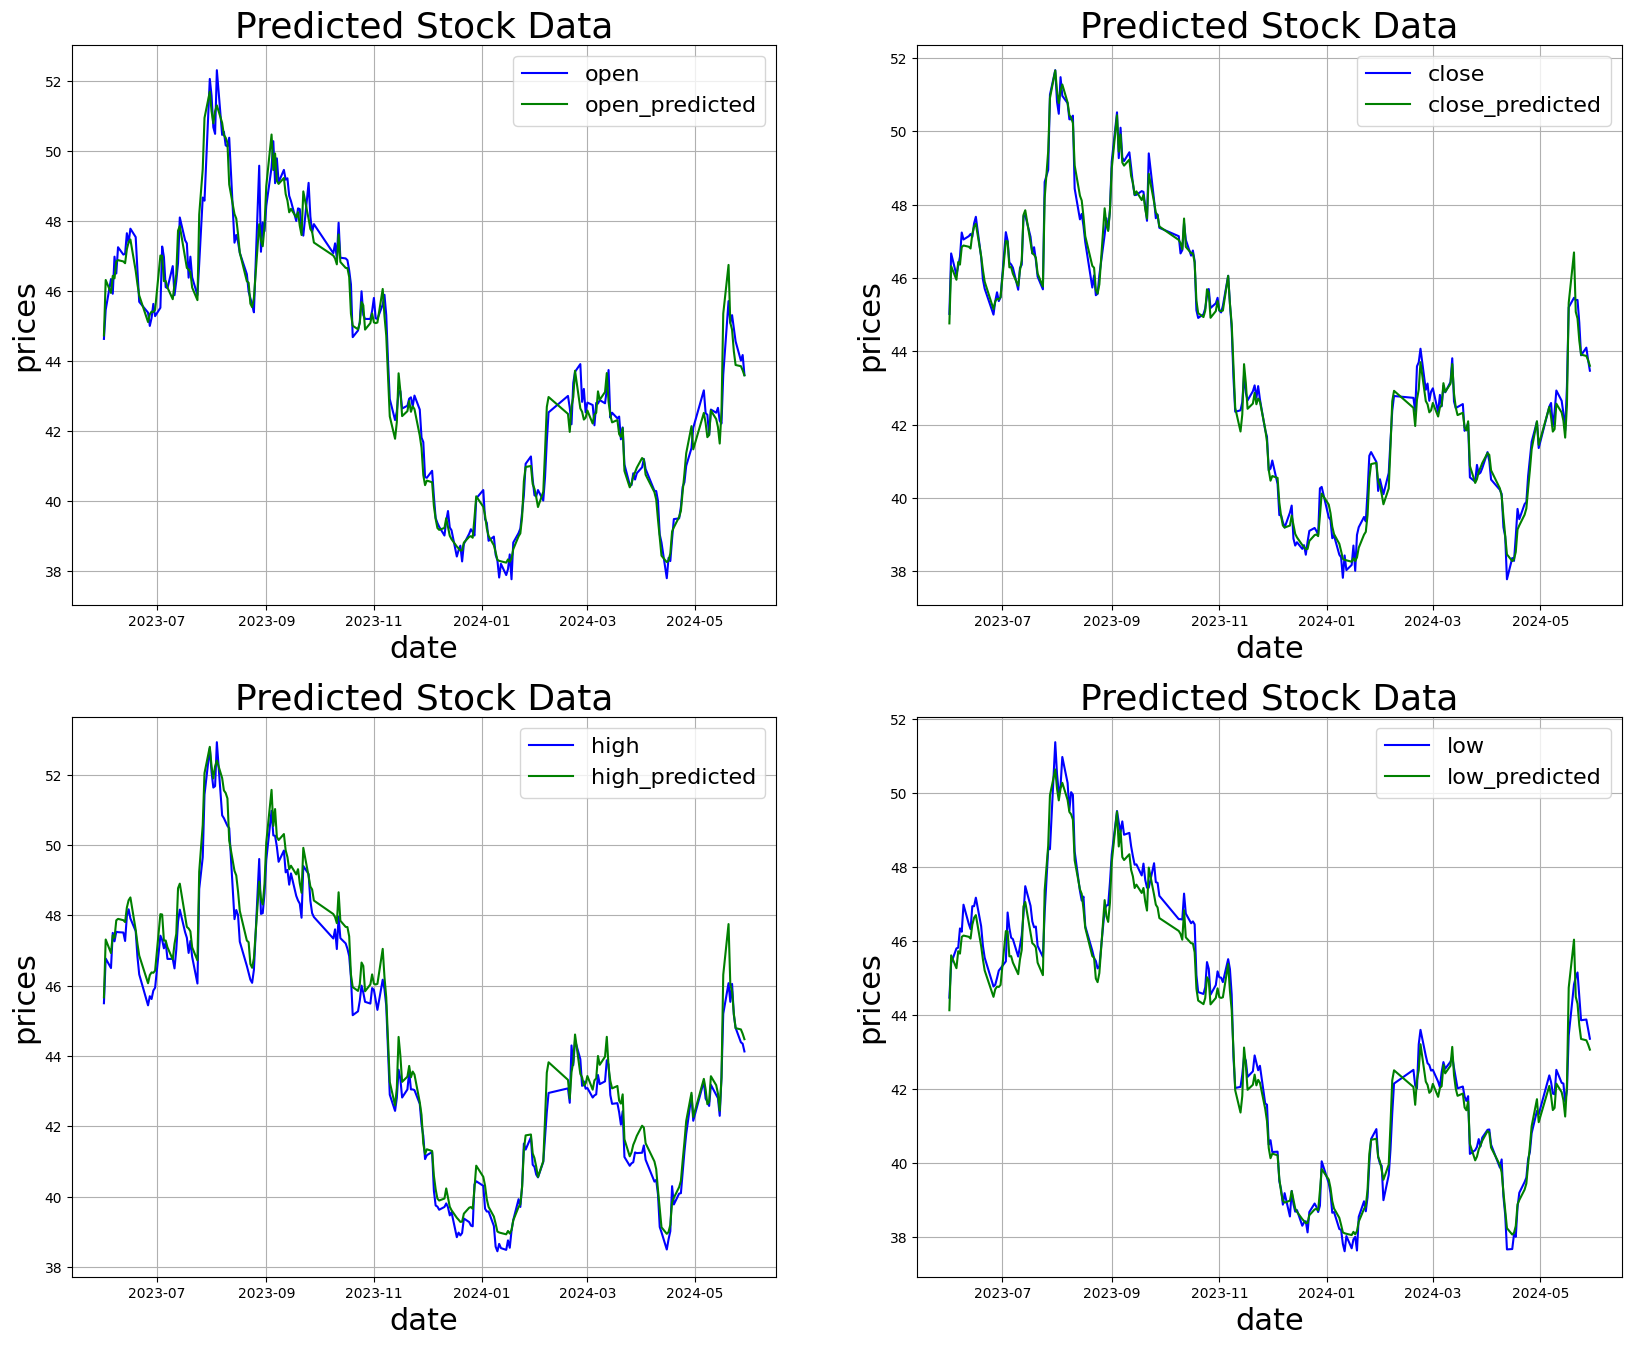

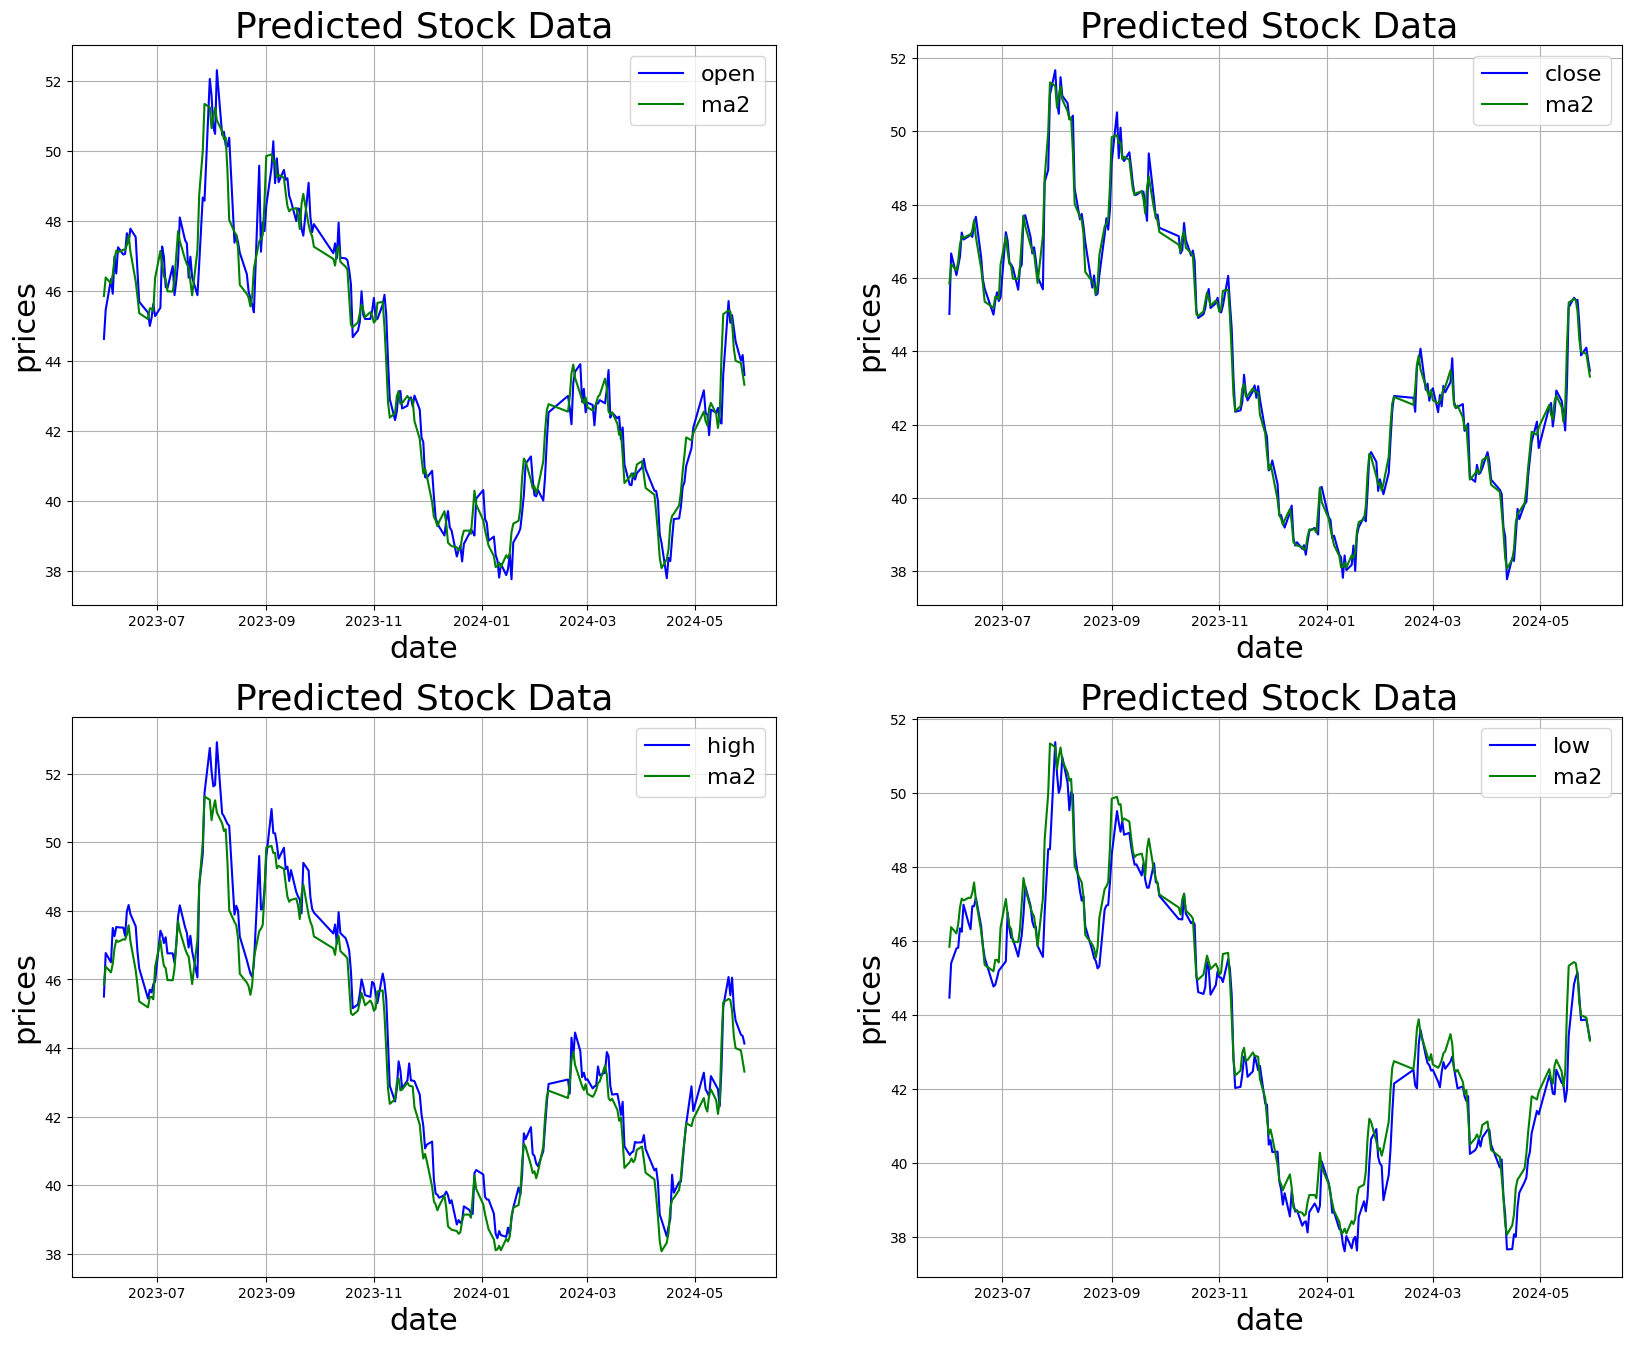

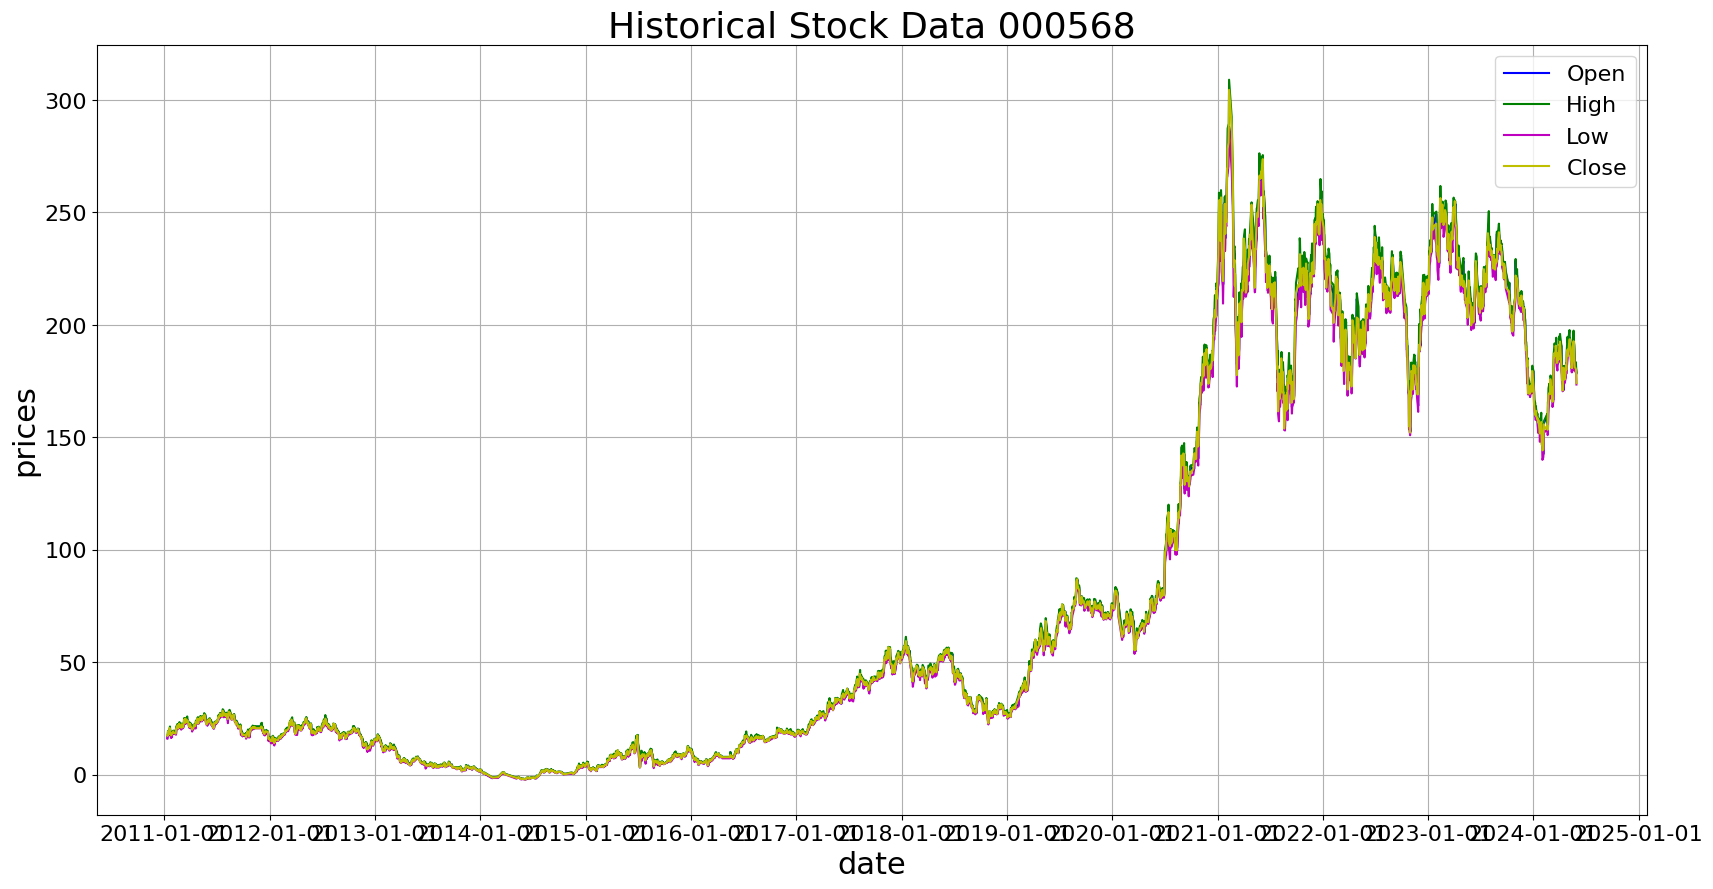

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, 20, 64)            17664     
                                                                 
 dropout_16 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_17 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_17 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_18 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_18 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_19 (LSTM)              (None, 128)              

Epoch 63/150
81/81 [==============================] - 1s 17ms/step - loss: 2.7734e-04 - val_loss: 3.2234e-04
Epoch 64/150
81/81 [==============================] - 1s 18ms/step - loss: 2.8756e-04 - val_loss: 3.0891e-04
Epoch 65/150
81/81 [==============================] - 1s 18ms/step - loss: 2.7602e-04 - val_loss: 5.1276e-04
Epoch 66/150
81/81 [==============================] - 2s 19ms/step - loss: 2.8028e-04 - val_loss: 3.3583e-04
Epoch 67/150
81/81 [==============================] - 1s 18ms/step - loss: 2.9931e-04 - val_loss: 3.9512e-04
Epoch 68/150
81/81 [==============================] - 1s 18ms/step - loss: 2.7506e-04 - val_loss: 5.1434e-04
Epoch 69/150
81/81 [==============================] - 2s 20ms/step - loss: 3.0728e-04 - val_loss: 2.9405e-04
Epoch 70/150
81/81 [==============================] - 2s 19ms/step - loss: 3.0580e-04 - val_loss: 0.0011
Epoch 71/150
81/81 [==============================] - 1s 17ms/step - loss: 2.7765e-04 - val_loss: 4.4457e-04
Epoch 72/150
81/81 [===

Epoch 138/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3698e-04 - val_loss: 7.5009e-04
Epoch 139/150
81/81 [==============================] - 1s 17ms/step - loss: 2.1683e-04 - val_loss: 3.2267e-04
Epoch 140/150
81/81 [==============================] - 1s 17ms/step - loss: 2.4570e-04 - val_loss: 2.5243e-04
Epoch 141/150
81/81 [==============================] - 1s 17ms/step - loss: 2.0635e-04 - val_loss: 4.7045e-04
Epoch 142/150
81/81 [==============================] - 1s 16ms/step - loss: 1.9166e-04 - val_loss: 2.4804e-04
Epoch 143/150
81/81 [==============================] - 1s 17ms/step - loss: 1.9668e-04 - val_loss: 4.0444e-04
Epoch 144/150
81/81 [==============================] - 1s 17ms/step - loss: 2.3754e-04 - val_loss: 5.2208e-04
Epoch 145/150
81/81 [==============================] - 1s 17ms/step - loss: 2.0365e-04 - val_loss: 2.8218e-04
Epoch 146/150
81/81 [==============================] - 1s 17ms/step - loss: 1.9496e-04 - val_loss: 2.4995e-04
Epoch 147/

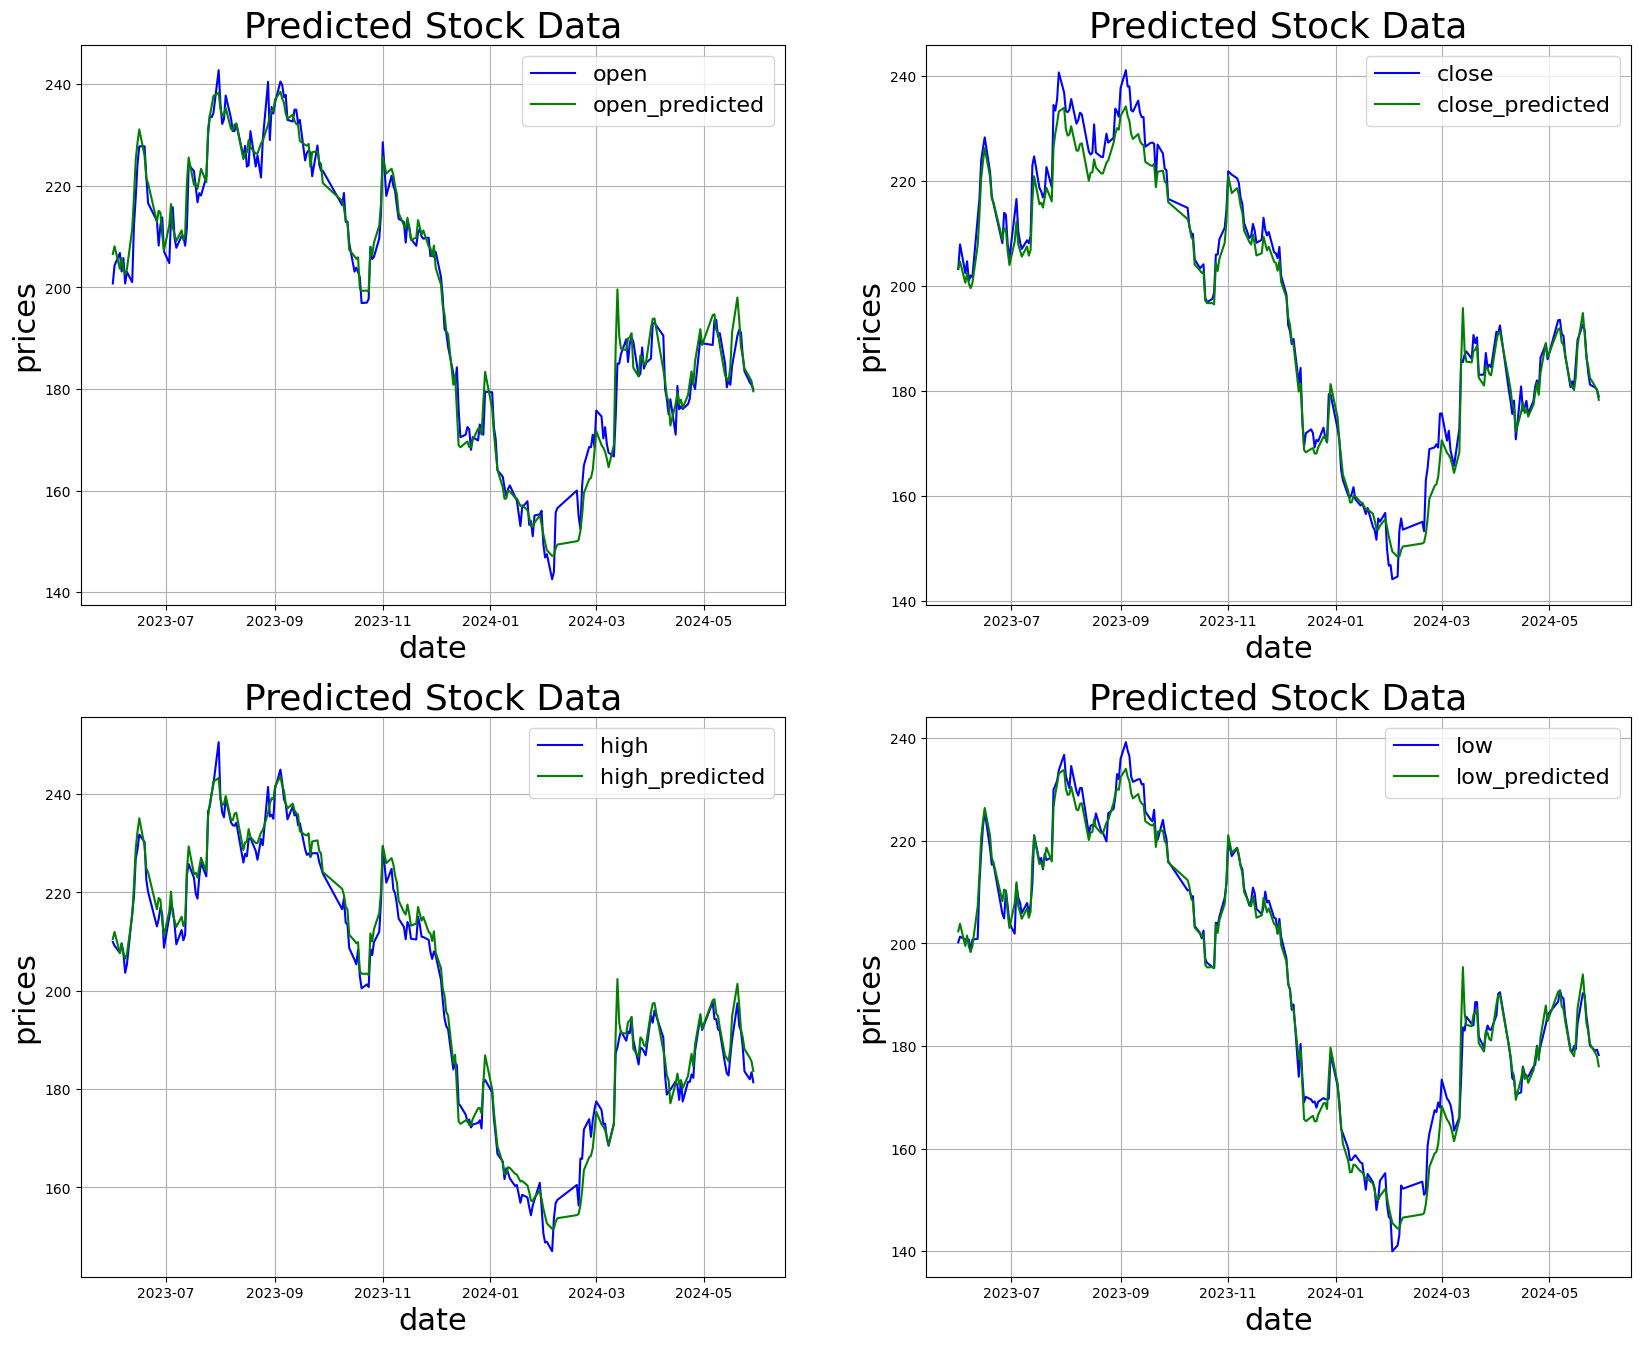

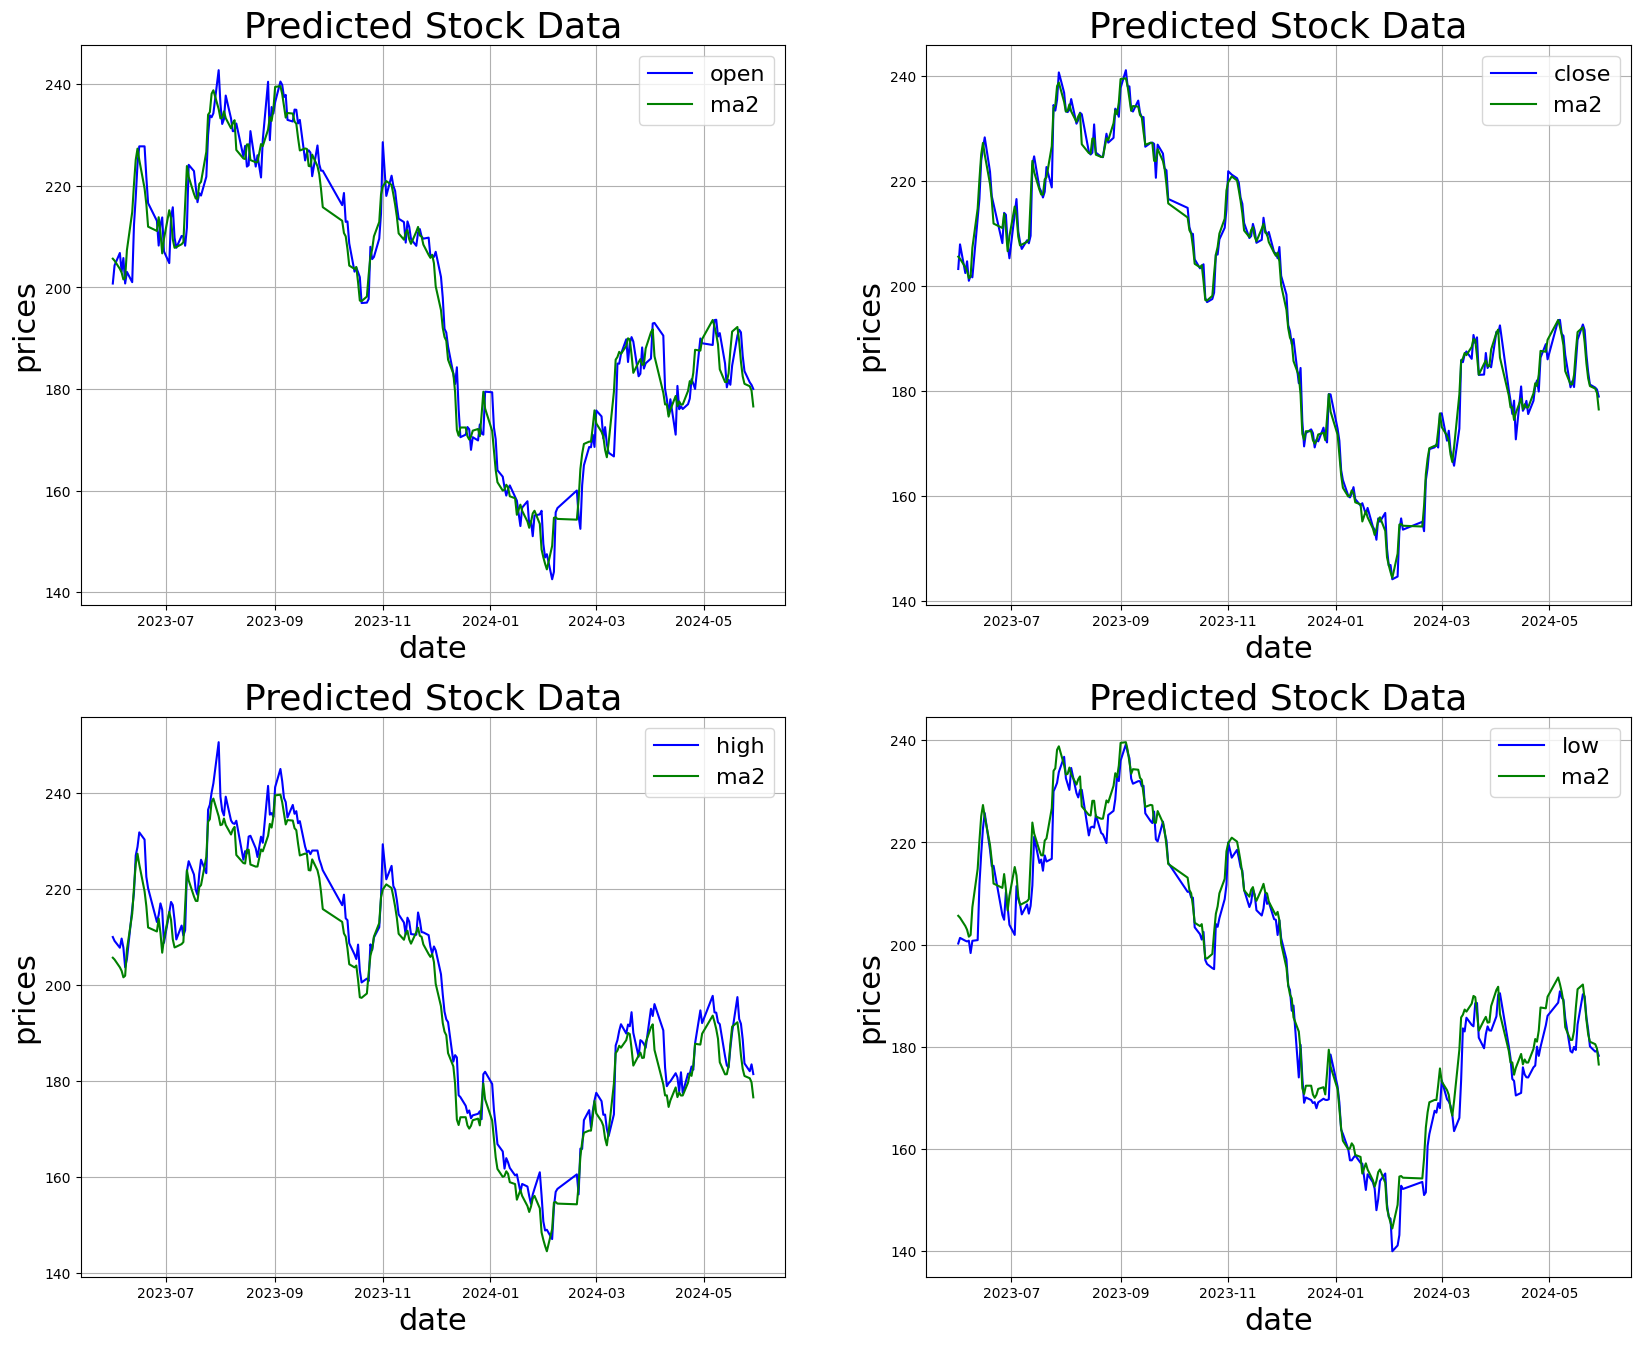

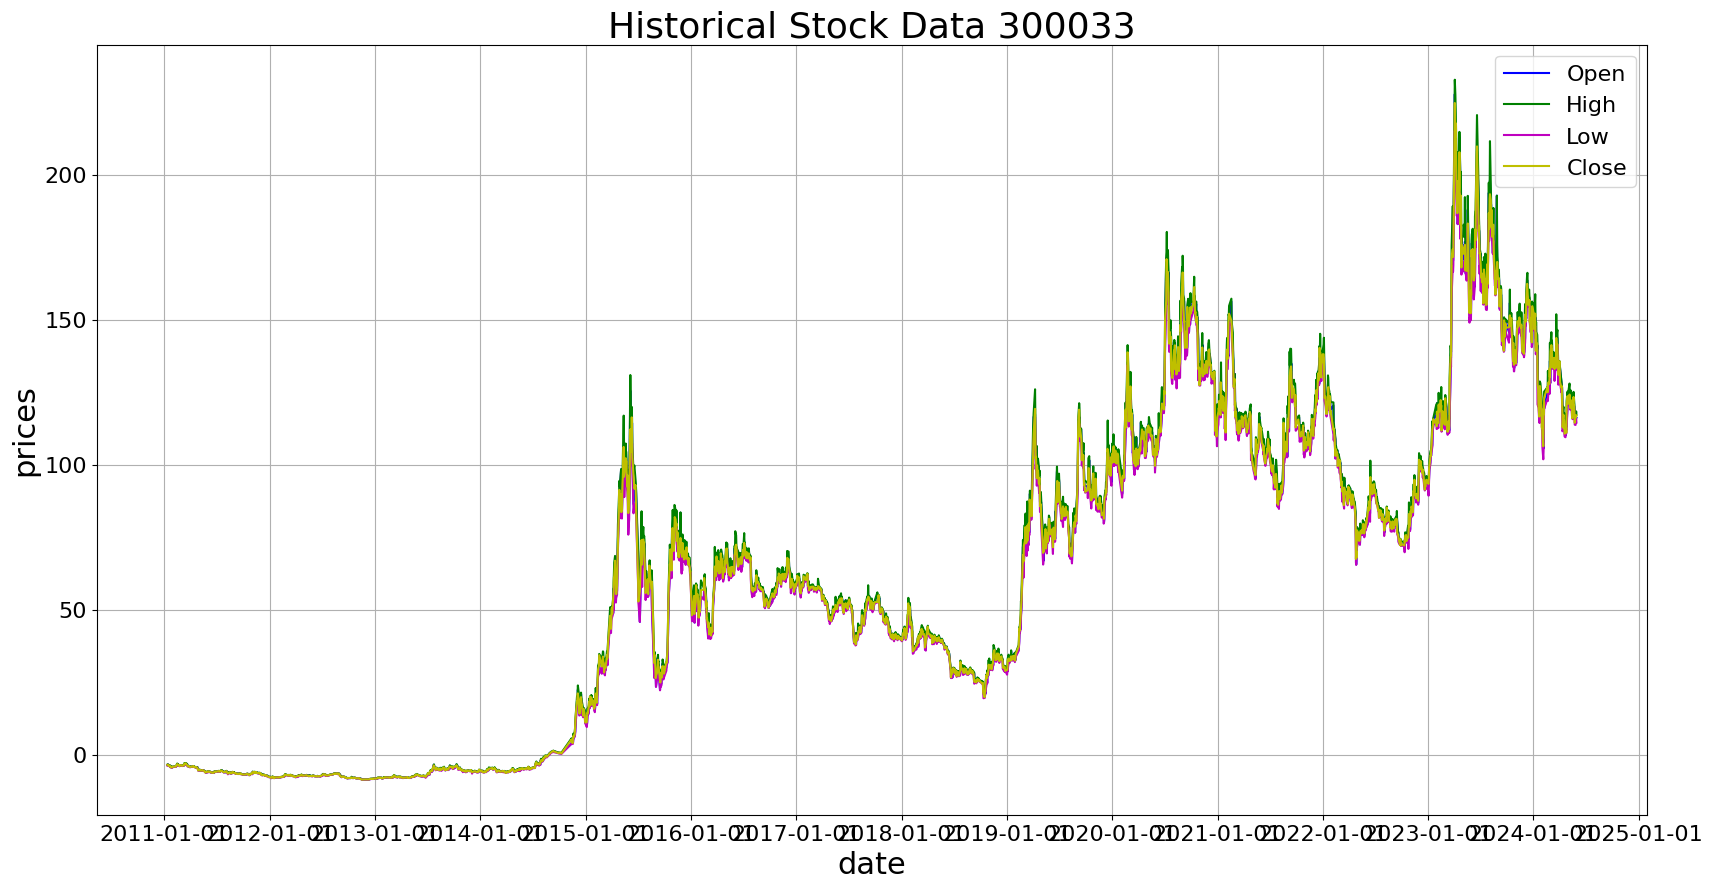

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 20, 64)            17664     
                                                                 
 dropout_20 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_21 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_21 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_22 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_22 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_23 (LSTM)              (None, 128)              

80/80 [==============================] - 1s 18ms/step - loss: 2.9204e-04 - val_loss: 6.0300e-04
Epoch 64/150
80/80 [==============================] - 1s 19ms/step - loss: 3.2948e-04 - val_loss: 7.9976e-04
Epoch 65/150
80/80 [==============================] - 1s 19ms/step - loss: 2.8012e-04 - val_loss: 5.8261e-04
Epoch 66/150
80/80 [==============================] - 1s 18ms/step - loss: 2.9943e-04 - val_loss: 8.0528e-04
Epoch 67/150
80/80 [==============================] - 1s 18ms/step - loss: 2.9962e-04 - val_loss: 8.1009e-04
Epoch 68/150
80/80 [==============================] - 1s 17ms/step - loss: 3.6979e-04 - val_loss: 9.5642e-04
Epoch 69/150
80/80 [==============================] - 1s 17ms/step - loss: 3.6162e-04 - val_loss: 6.6661e-04
Epoch 70/150
80/80 [==============================] - 1s 16ms/step - loss: 2.9061e-04 - val_loss: 8.4072e-04
Epoch 71/150
80/80 [==============================] - 1s 18ms/step - loss: 3.0717e-04 - val_loss: 7.8534e-04
Epoch 72/150
80/80 [============

80/80 [==============================] - 1s 17ms/step - loss: 2.2941e-04 - val_loss: 6.8868e-04
Epoch 139/150
80/80 [==============================] - 1s 16ms/step - loss: 2.4709e-04 - val_loss: 7.7937e-04
Epoch 140/150
80/80 [==============================] - 1s 16ms/step - loss: 2.6315e-04 - val_loss: 6.2891e-04
Epoch 141/150
80/80 [==============================] - 1s 16ms/step - loss: 2.4759e-04 - val_loss: 8.8417e-04
Epoch 142/150
80/80 [==============================] - 1s 16ms/step - loss: 2.4987e-04 - val_loss: 6.8612e-04
Epoch 143/150
80/80 [==============================] - 1s 17ms/step - loss: 2.5498e-04 - val_loss: 8.3240e-04
Epoch 144/150
80/80 [==============================] - 1s 17ms/step - loss: 2.4421e-04 - val_loss: 7.2760e-04
Epoch 145/150
80/80 [==============================] - 1s 15ms/step - loss: 2.6768e-04 - val_loss: 9.3752e-04
Epoch 146/150
80/80 [==============================] - 1s 16ms/step - loss: 2.3091e-04 - val_loss: 6.3915e-04
Epoch 147/150
80/80 [===

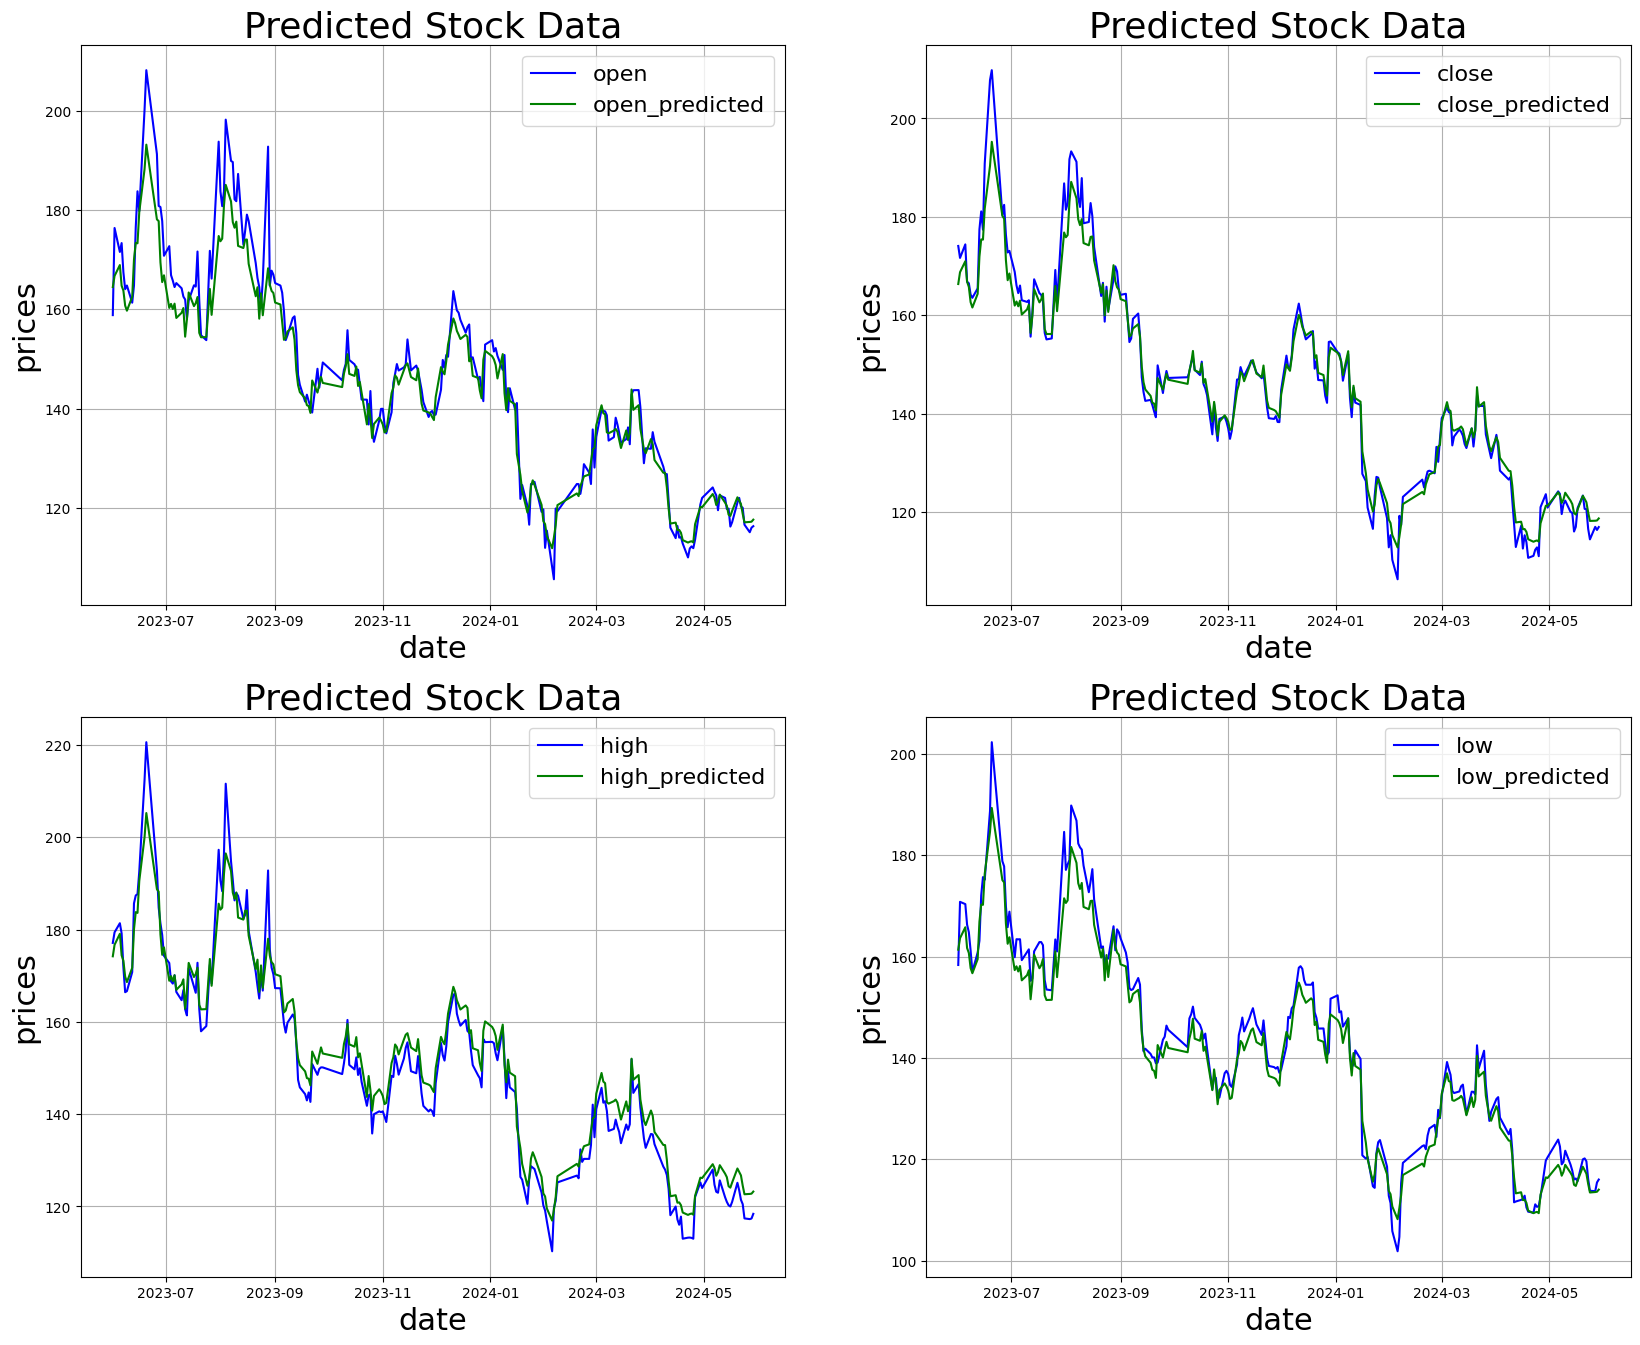

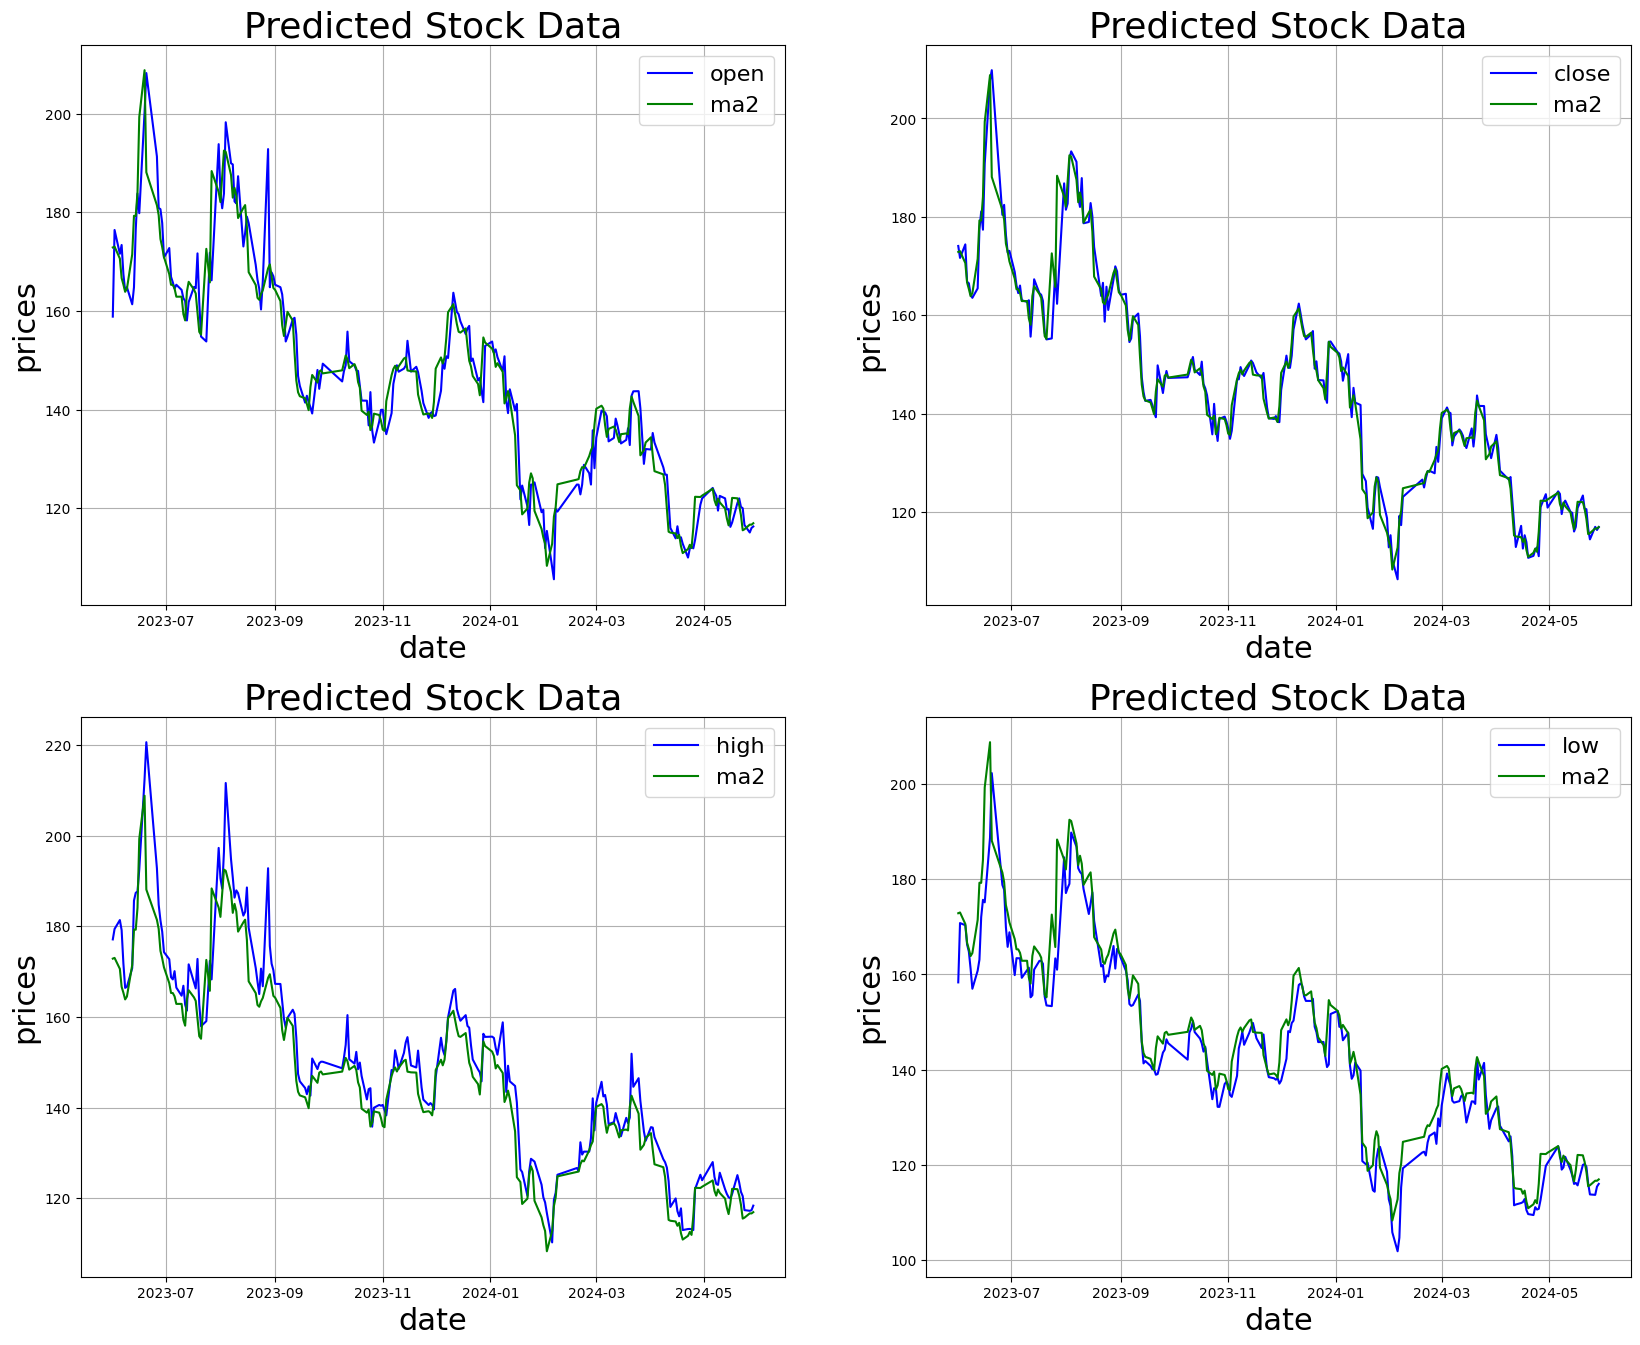

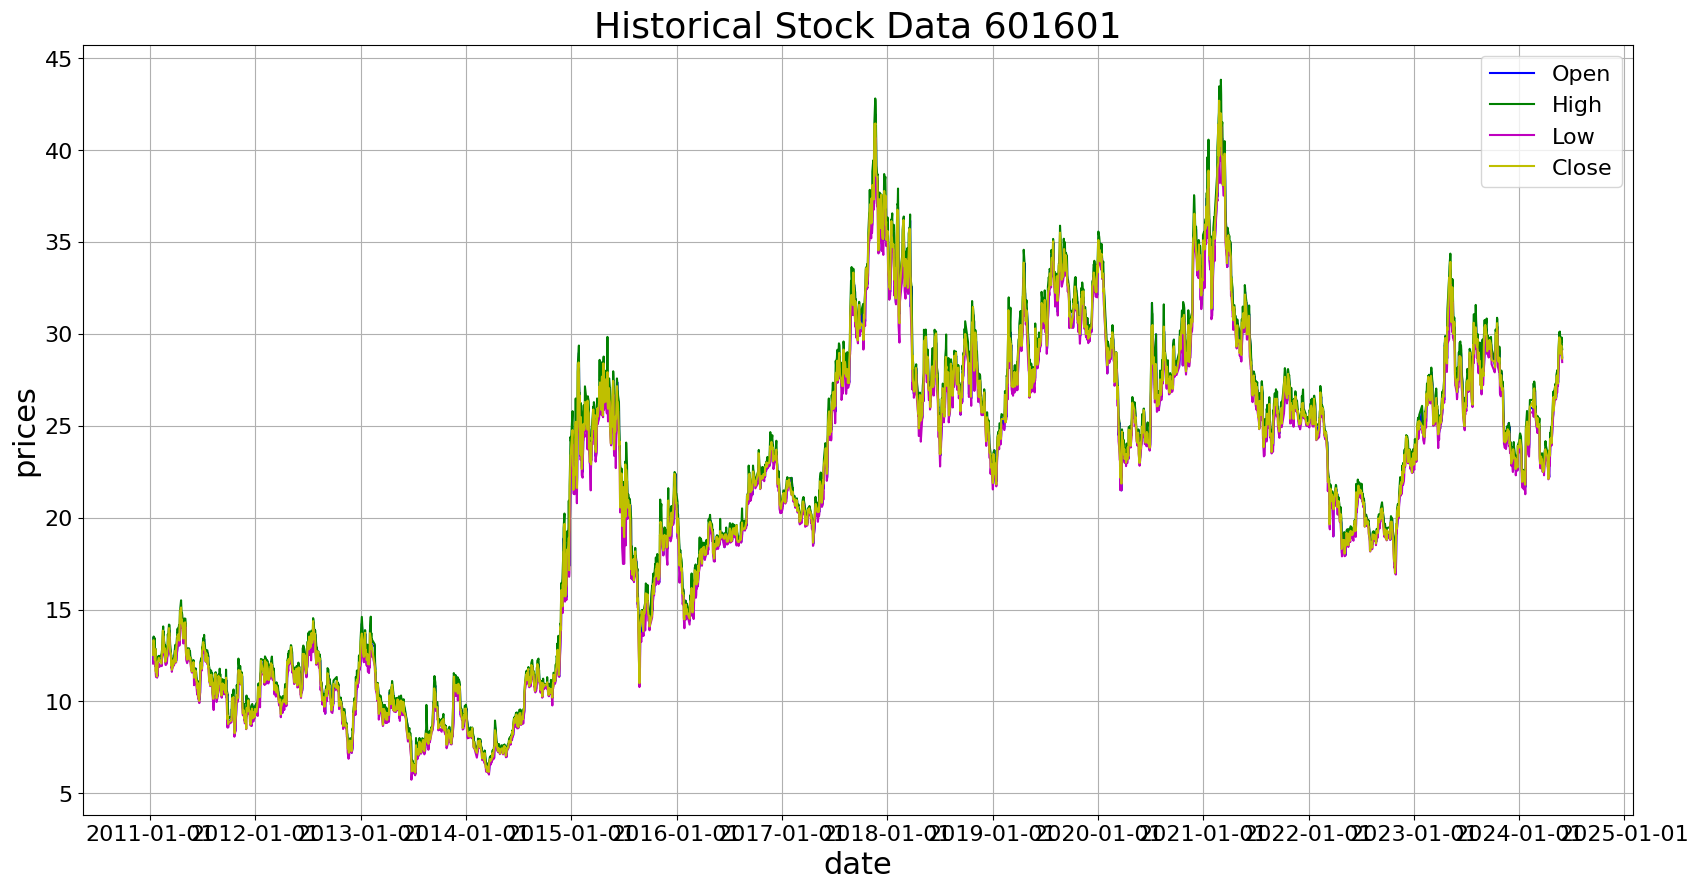

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_24 (LSTM)              (None, 20, 64)            17664     
                                                                 
 dropout_24 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_25 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_25 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_26 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_26 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_27 (LSTM)              (None, 128)              

84/84 [==============================] - 1s 17ms/step - loss: 4.5637e-04 - val_loss: 1.6663e-04
Epoch 63/150
84/84 [==============================] - 1s 18ms/step - loss: 4.3144e-04 - val_loss: 1.5892e-04
Epoch 64/150
84/84 [==============================] - 1s 17ms/step - loss: 4.4348e-04 - val_loss: 1.6382e-04
Epoch 65/150
84/84 [==============================] - 1s 17ms/step - loss: 4.2114e-04 - val_loss: 1.5049e-04
Epoch 66/150
84/84 [==============================] - 1s 17ms/step - loss: 4.2083e-04 - val_loss: 1.3894e-04
Epoch 67/150
84/84 [==============================] - 1s 17ms/step - loss: 4.1570e-04 - val_loss: 1.4612e-04
Epoch 68/150
84/84 [==============================] - 1s 17ms/step - loss: 4.1294e-04 - val_loss: 1.9562e-04
Epoch 69/150
84/84 [==============================] - 1s 17ms/step - loss: 4.4375e-04 - val_loss: 1.9523e-04
Epoch 70/150
84/84 [==============================] - 1s 17ms/step - loss: 4.2166e-04 - val_loss: 2.0808e-04
Epoch 71/150
84/84 [============

Epoch 137/150
84/84 [==============================] - 1s 17ms/step - loss: 3.6923e-04 - val_loss: 2.2032e-04
Epoch 138/150
84/84 [==============================] - 1s 18ms/step - loss: 3.3618e-04 - val_loss: 1.8936e-04
Epoch 139/150
84/84 [==============================] - 1s 16ms/step - loss: 3.5712e-04 - val_loss: 1.6414e-04
Epoch 140/150
84/84 [==============================] - 1s 16ms/step - loss: 3.6024e-04 - val_loss: 1.6277e-04
Epoch 141/150
84/84 [==============================] - 1s 16ms/step - loss: 3.3942e-04 - val_loss: 1.4538e-04
Epoch 142/150
84/84 [==============================] - 1s 16ms/step - loss: 3.9042e-04 - val_loss: 2.6062e-04
Epoch 143/150
84/84 [==============================] - 1s 15ms/step - loss: 3.6557e-04 - val_loss: 1.8125e-04
Epoch 144/150
84/84 [==============================] - 1s 16ms/step - loss: 3.9211e-04 - val_loss: 1.6010e-04
Epoch 145/150
84/84 [==============================] - 1s 16ms/step - loss: 3.5729e-04 - val_loss: 1.7938e-04
Epoch 146/

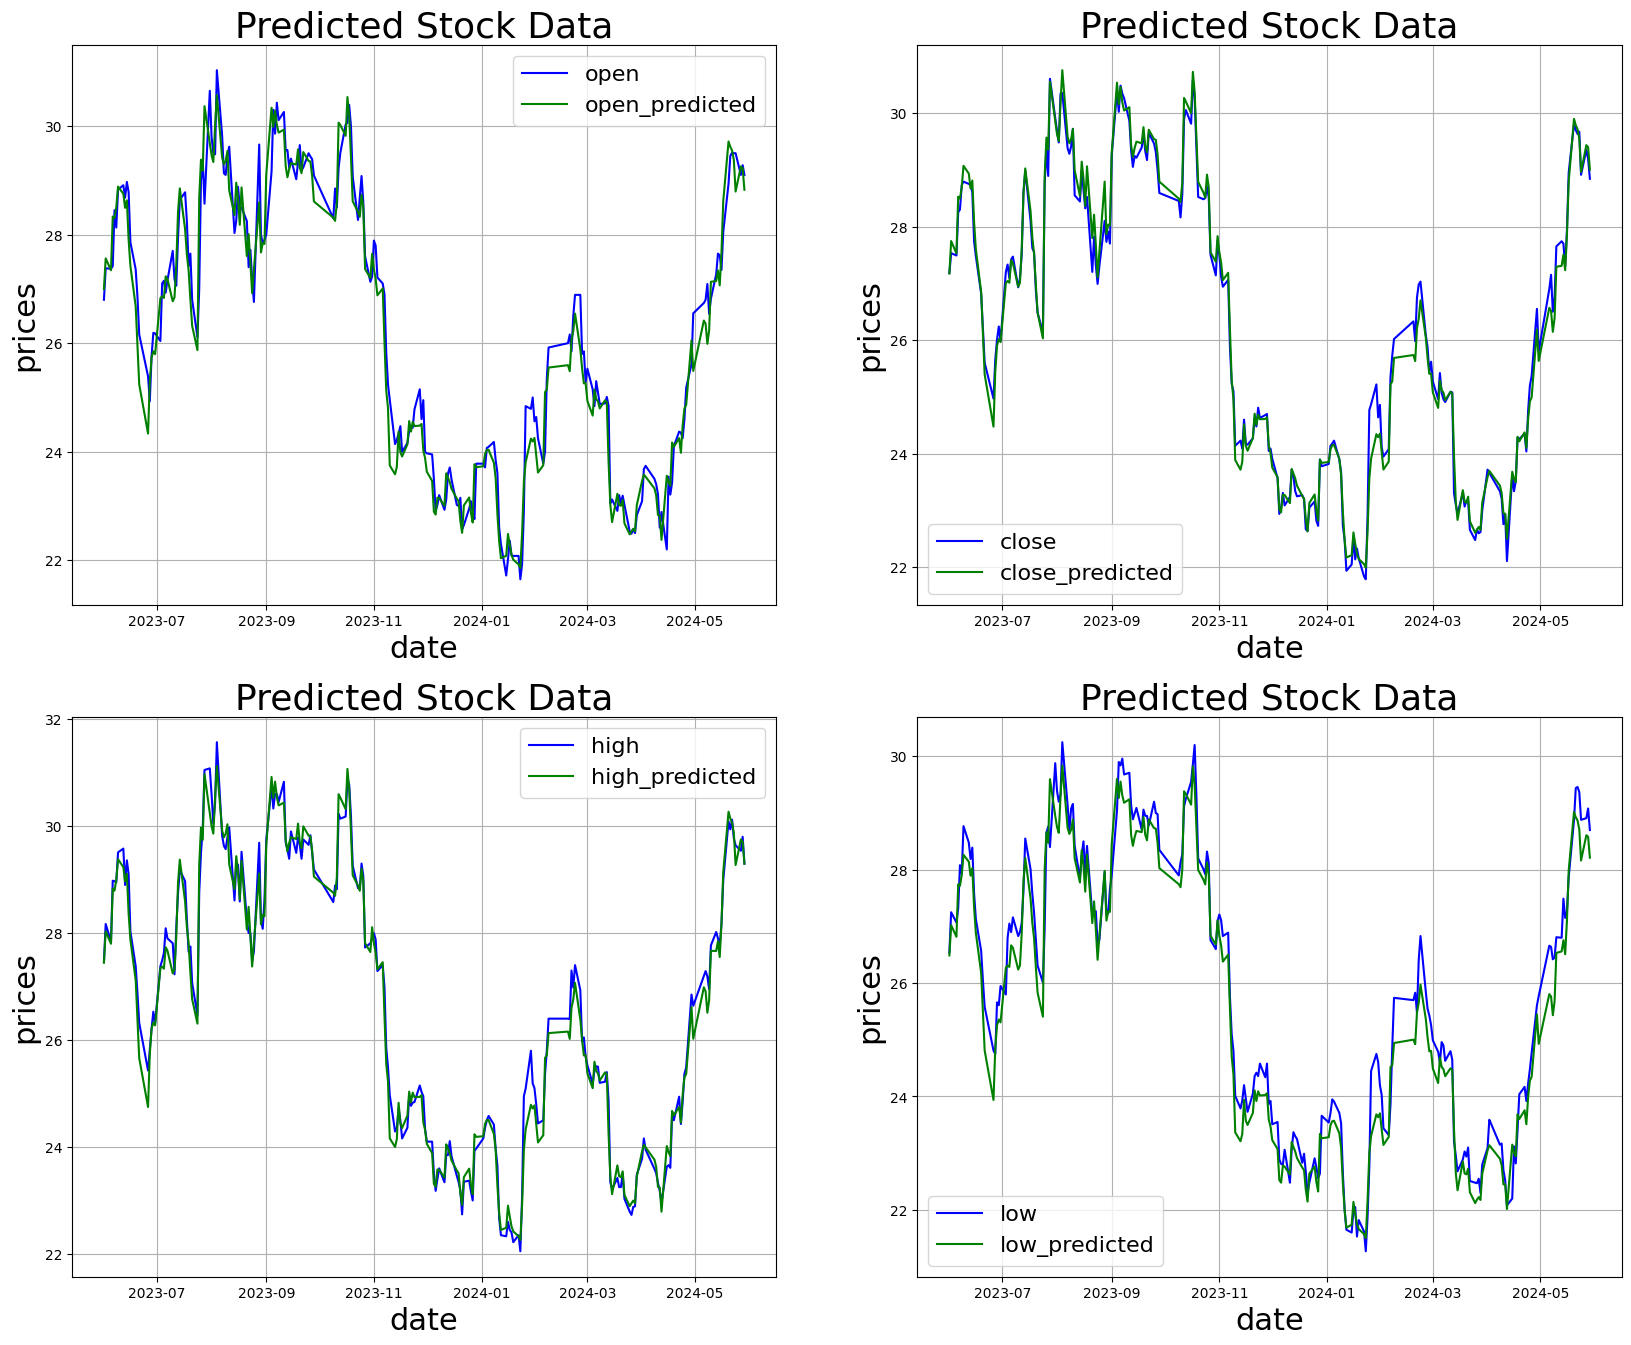

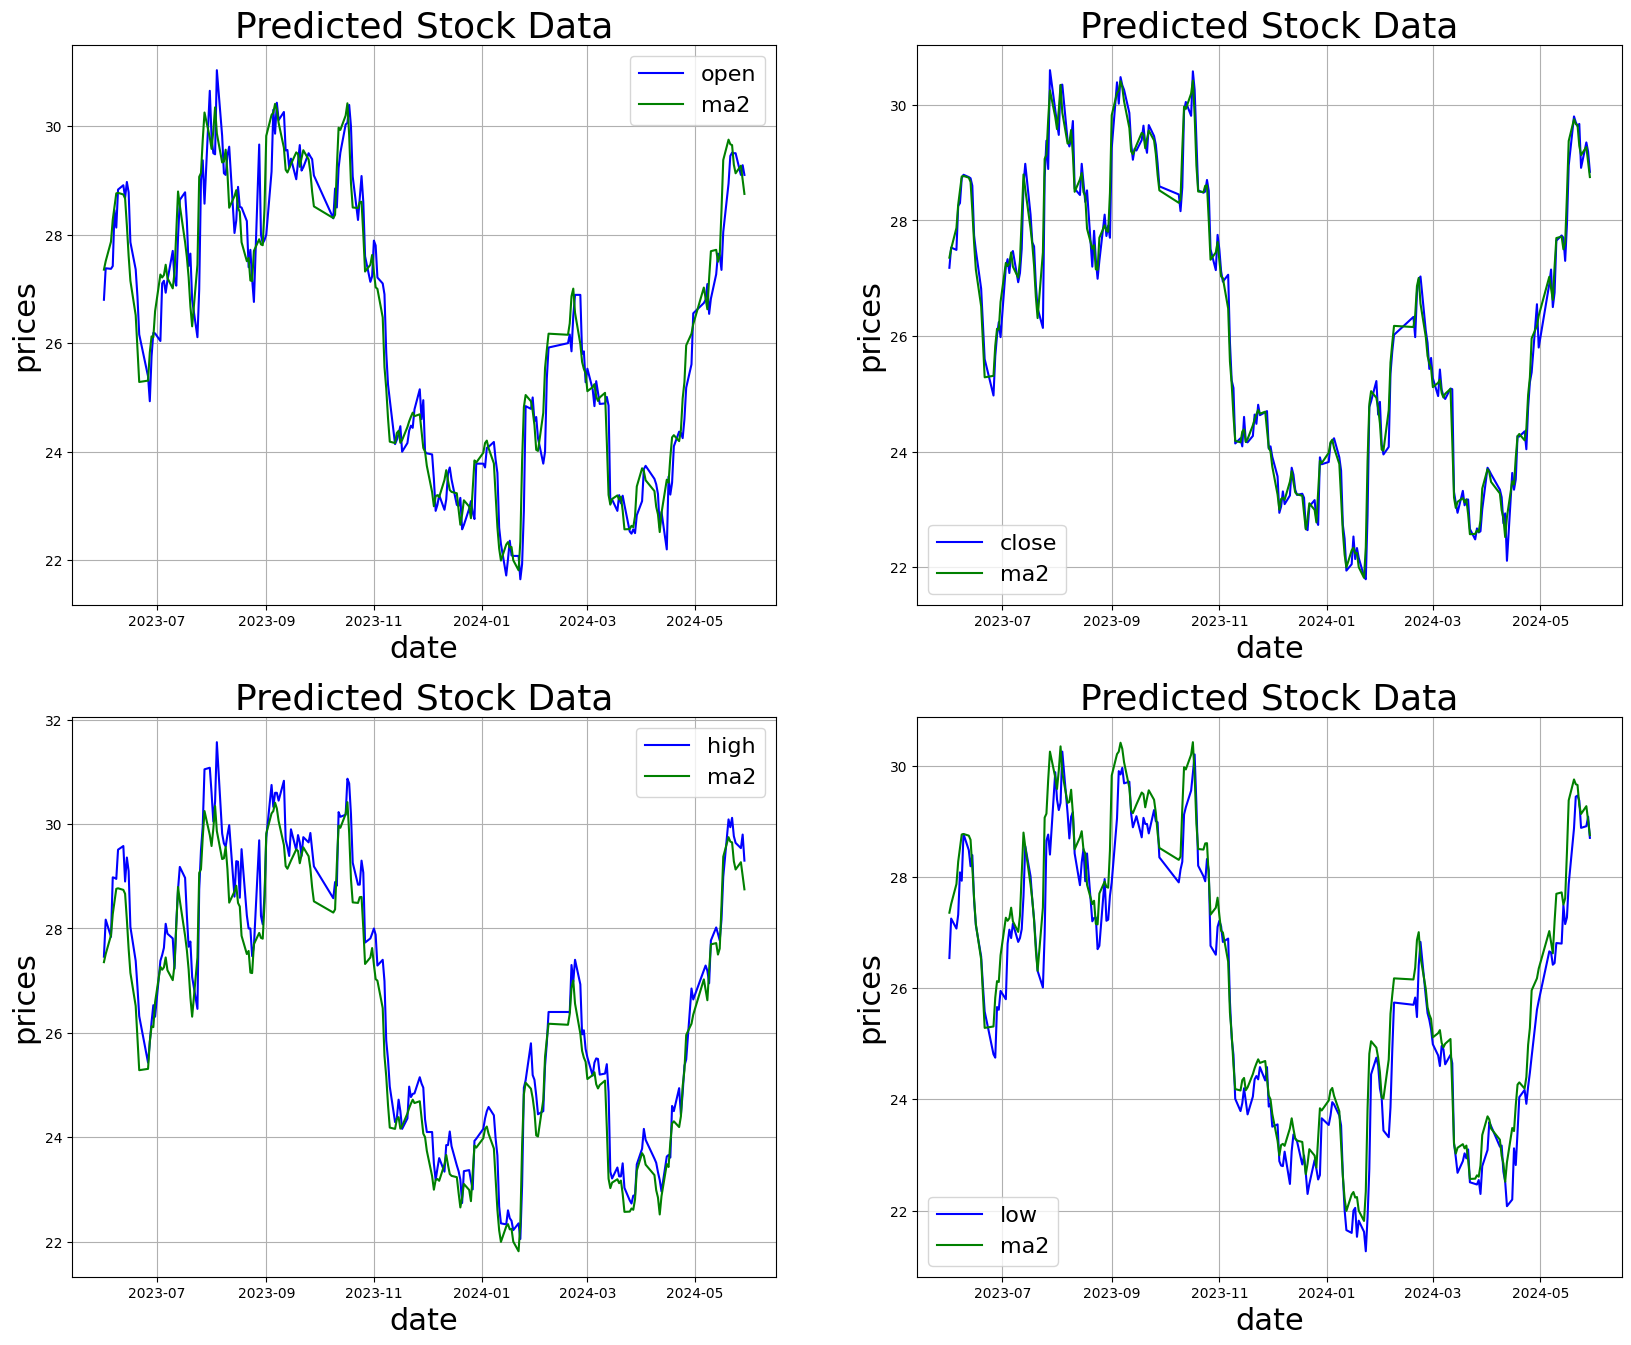

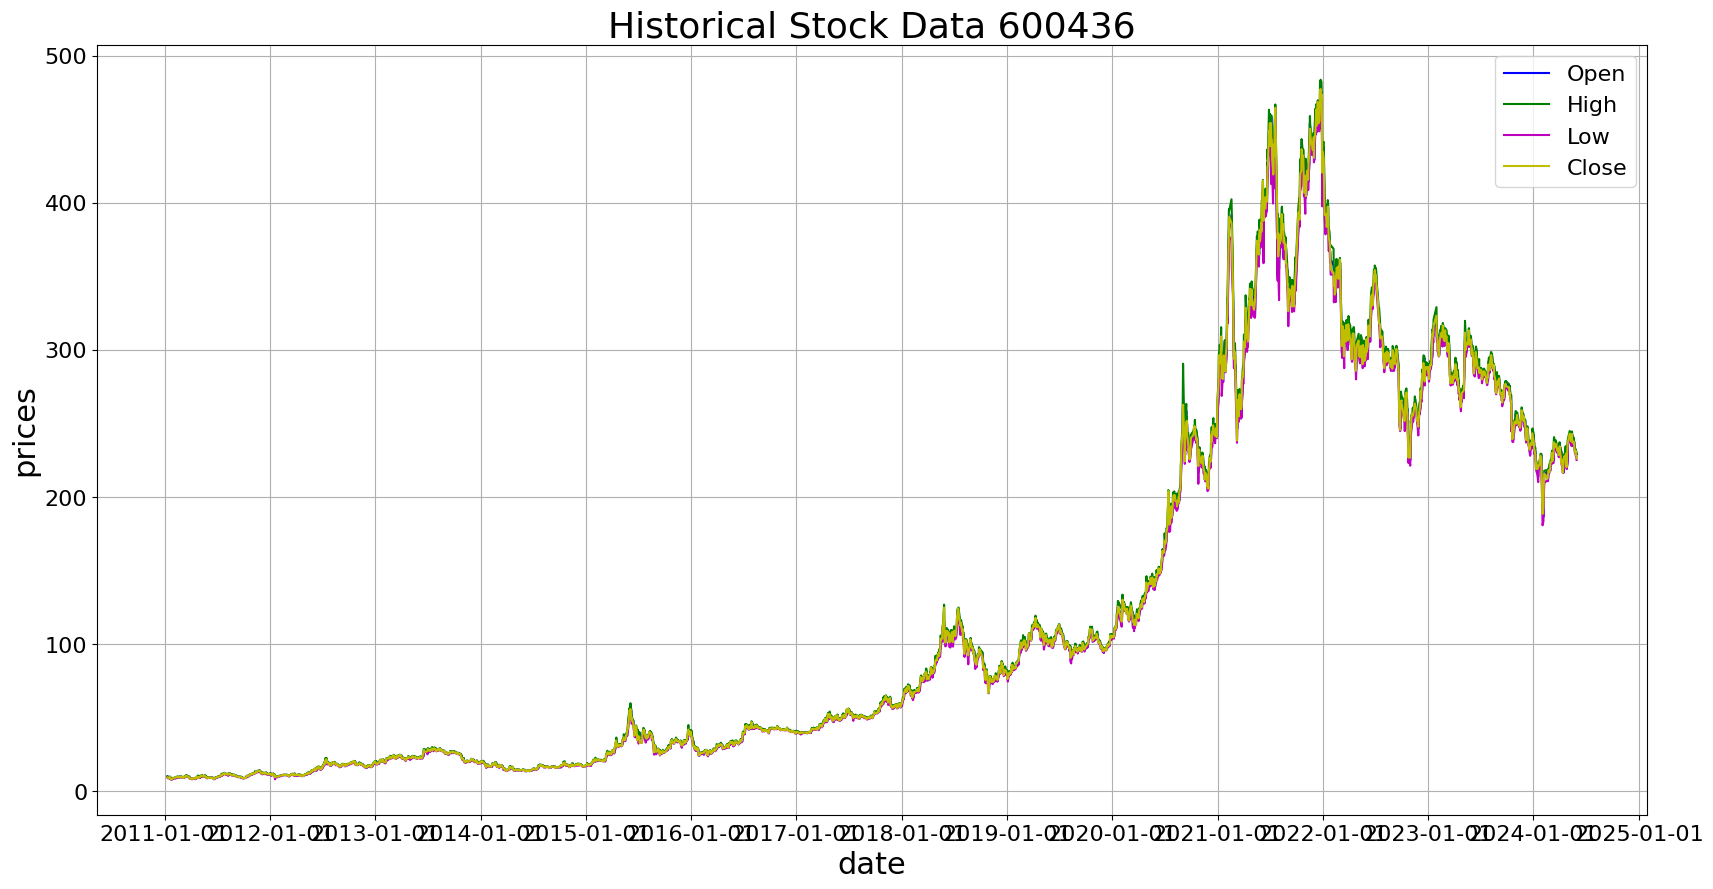

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_28 (LSTM)              (None, 20, 64)            17664     
                                                                 
 dropout_28 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_29 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_29 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_30 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_30 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_31 (LSTM)              (None, 128)              

Epoch 63/150
83/83 [==============================] - 1s 17ms/step - loss: 2.9841e-04 - val_loss: 0.0013
Epoch 64/150
83/83 [==============================] - 1s 16ms/step - loss: 2.8282e-04 - val_loss: 2.9618e-04
Epoch 65/150
83/83 [==============================] - 1s 17ms/step - loss: 3.1951e-04 - val_loss: 3.0186e-04
Epoch 66/150
83/83 [==============================] - 1s 17ms/step - loss: 3.0963e-04 - val_loss: 3.1078e-04
Epoch 67/150
83/83 [==============================] - 1s 16ms/step - loss: 3.1110e-04 - val_loss: 0.0011
Epoch 68/150
83/83 [==============================] - 1s 17ms/step - loss: 2.8820e-04 - val_loss: 3.8222e-04
Epoch 69/150
83/83 [==============================] - 1s 18ms/step - loss: 2.5255e-04 - val_loss: 0.0012
Epoch 70/150
83/83 [==============================] - 1s 18ms/step - loss: 2.5584e-04 - val_loss: 3.2420e-04
Epoch 71/150
83/83 [==============================] - 1s 17ms/step - loss: 2.8868e-04 - val_loss: 2.9274e-04
Epoch 72/150
83/83 [===========

83/83 [==============================] - 1s 18ms/step - loss: 2.0521e-04 - val_loss: 2.6467e-04
Epoch 139/150
83/83 [==============================] - 1s 17ms/step - loss: 2.2664e-04 - val_loss: 4.1005e-04
Epoch 140/150
83/83 [==============================] - 1s 16ms/step - loss: 2.0208e-04 - val_loss: 7.0753e-04
Epoch 141/150
83/83 [==============================] - 1s 17ms/step - loss: 2.1565e-04 - val_loss: 2.2529e-04
Epoch 142/150
83/83 [==============================] - 2s 18ms/step - loss: 2.0445e-04 - val_loss: 4.2151e-04
Epoch 143/150
83/83 [==============================] - 1s 17ms/step - loss: 2.4742e-04 - val_loss: 0.0026
Epoch 144/150
83/83 [==============================] - 1s 17ms/step - loss: 3.1051e-04 - val_loss: 3.4592e-04
Epoch 145/150
83/83 [==============================] - 1s 16ms/step - loss: 2.2475e-04 - val_loss: 4.7506e-04
Epoch 146/150
83/83 [==============================] - 1s 17ms/step - loss: 2.1856e-04 - val_loss: 1.9335e-04
Epoch 147/150
83/83 [=======

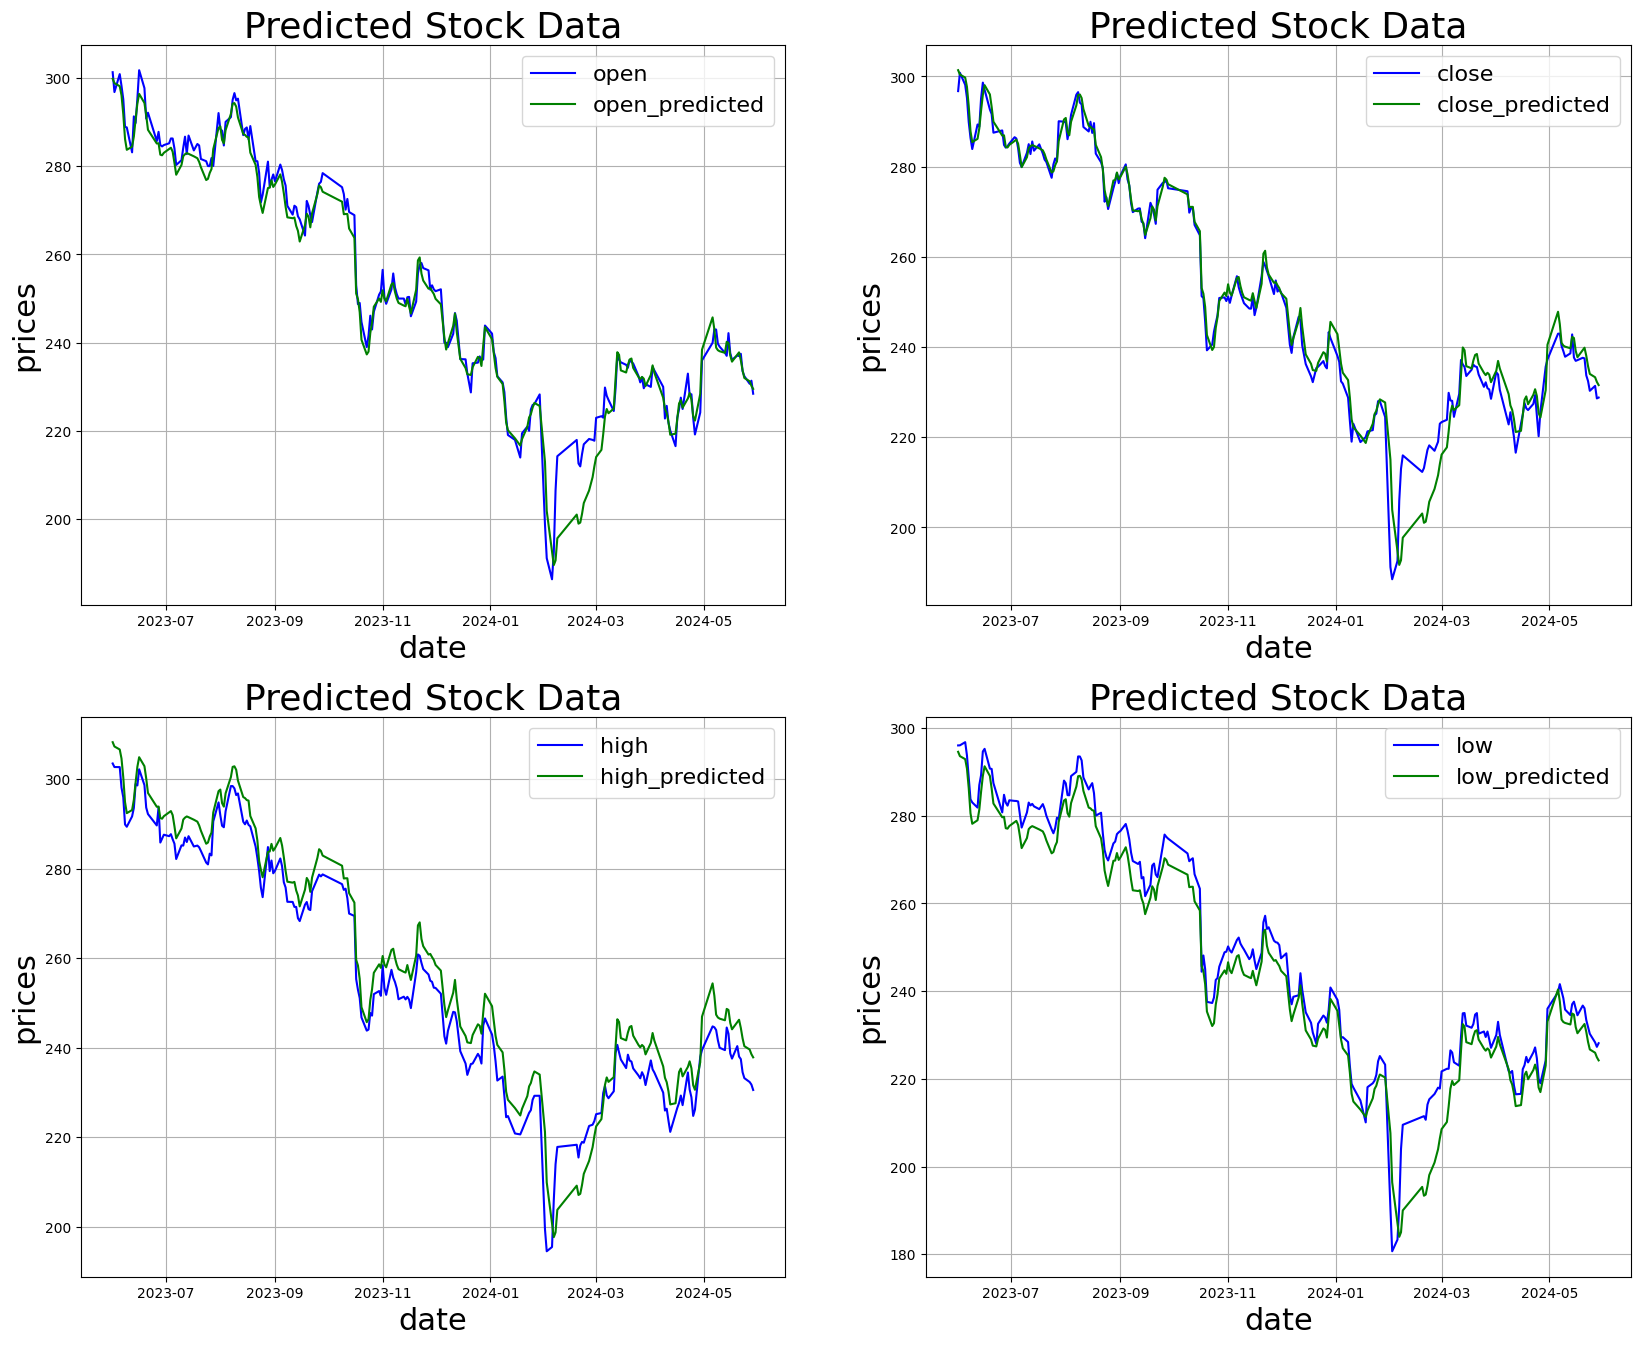

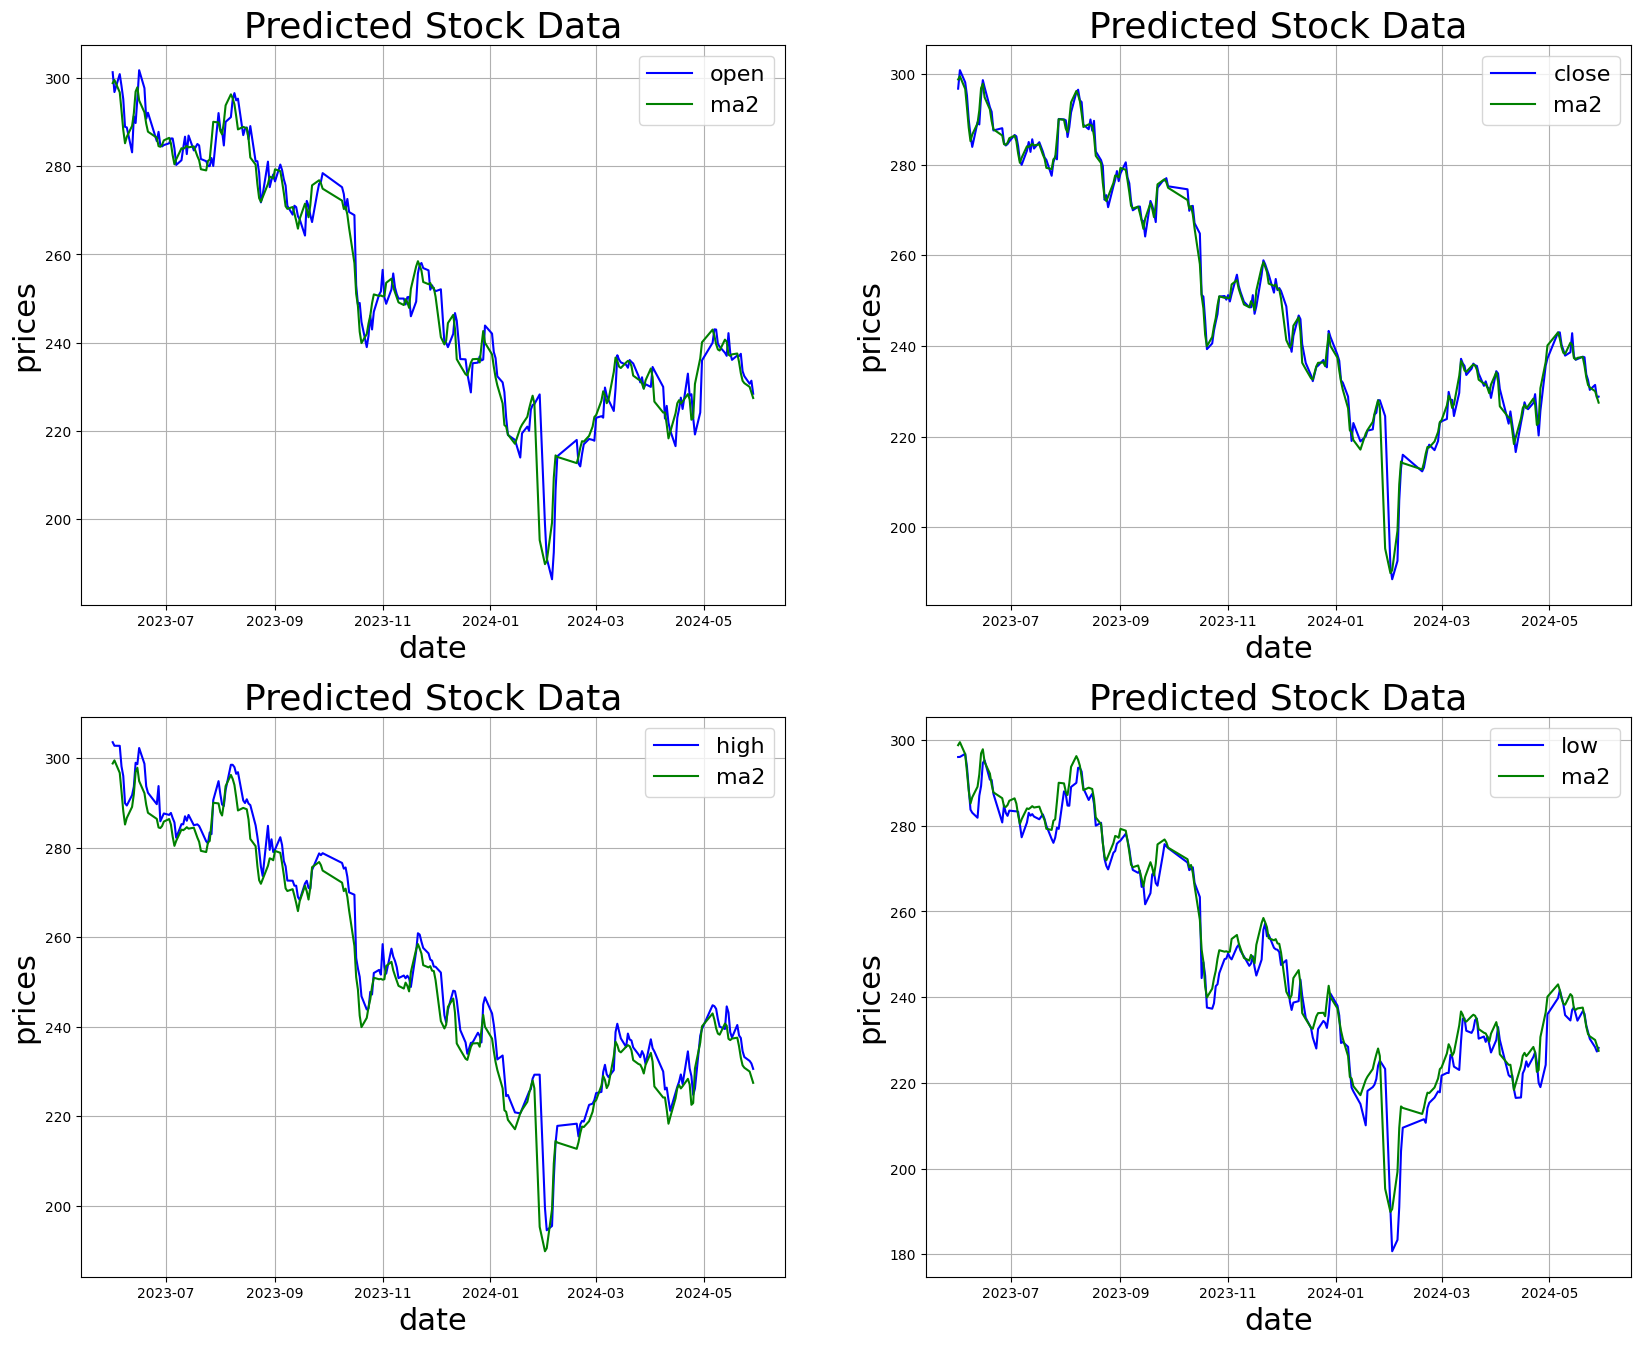

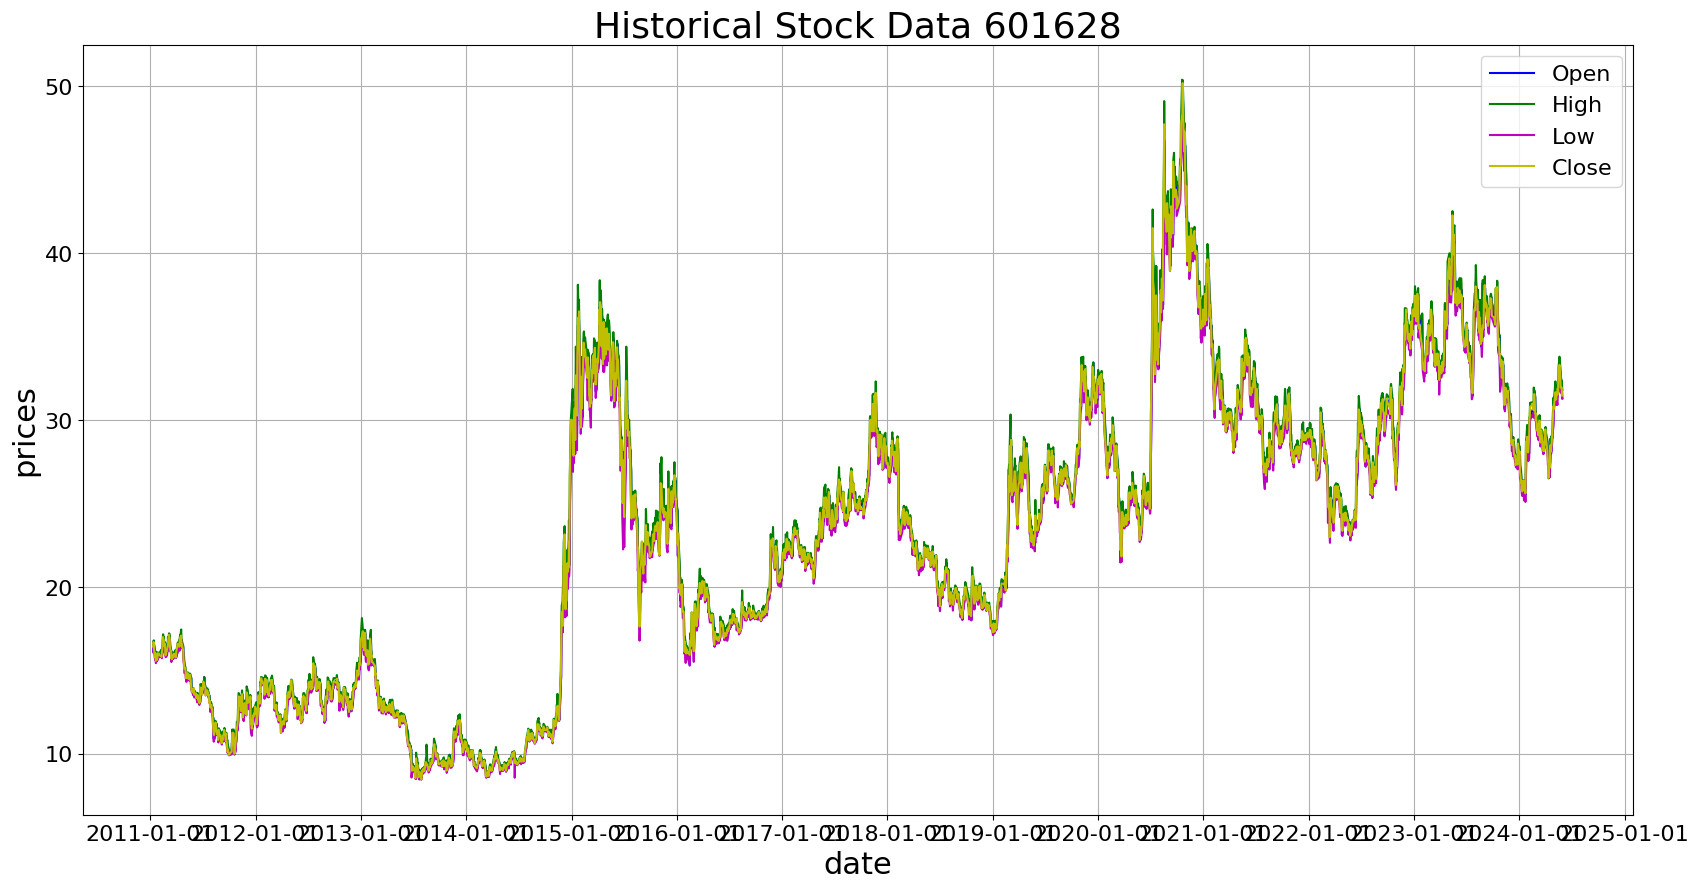

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 20, 64)            17664     
                                                                 
 dropout_32 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_33 (LSTM)              (None, 20, 64)            33024     
                                                                 
 dropout_33 (Dropout)        (None, 20, 64)            0         
                                                                 
 lstm_34 (LSTM)              (None, 20, 80)            46400     
                                                                 
 dropout_34 (Dropout)        (None, 20, 80)            0         
                                                                 
 lstm_35 (LSTM)              (None, 128)              

84/84 [==============================] - 1s 17ms/step - loss: 4.1548e-04 - val_loss: 4.7754e-04
Epoch 63/150
84/84 [==============================] - 1s 17ms/step - loss: 3.8044e-04 - val_loss: 2.1012e-04
Epoch 64/150
84/84 [==============================] - 1s 17ms/step - loss: 3.4980e-04 - val_loss: 2.0549e-04
Epoch 65/150
84/84 [==============================] - 2s 18ms/step - loss: 3.6223e-04 - val_loss: 2.9276e-04
Epoch 66/150
84/84 [==============================] - 1s 17ms/step - loss: 3.9699e-04 - val_loss: 2.0325e-04
Epoch 67/150
84/84 [==============================] - 2s 19ms/step - loss: 3.6552e-04 - val_loss: 3.2465e-04
Epoch 68/150
84/84 [==============================] - 2s 18ms/step - loss: 3.9205e-04 - val_loss: 3.4849e-04
Epoch 69/150
84/84 [==============================] - 1s 17ms/step - loss: 3.5475e-04 - val_loss: 1.7492e-04
Epoch 70/150
84/84 [==============================] - 1s 17ms/step - loss: 3.8718e-04 - val_loss: 1.9041e-04
Epoch 71/150
84/84 [============

Epoch 137/150
84/84 [==============================] - 1s 16ms/step - loss: 2.9002e-04 - val_loss: 3.2140e-04
Epoch 138/150
84/84 [==============================] - 1s 17ms/step - loss: 2.9783e-04 - val_loss: 1.9042e-04
Epoch 139/150
84/84 [==============================] - 1s 16ms/step - loss: 3.1000e-04 - val_loss: 2.1269e-04
Epoch 140/150
84/84 [==============================] - 2s 18ms/step - loss: 2.9482e-04 - val_loss: 1.7769e-04
Epoch 141/150
84/84 [==============================] - 1s 17ms/step - loss: 2.9918e-04 - val_loss: 2.0664e-04
Epoch 142/150
84/84 [==============================] - 1s 16ms/step - loss: 2.9331e-04 - val_loss: 2.3839e-04
Epoch 143/150
84/84 [==============================] - 1s 17ms/step - loss: 2.7541e-04 - val_loss: 2.0102e-04
Epoch 144/150
84/84 [==============================] - 1s 17ms/step - loss: 2.8004e-04 - val_loss: 1.7563e-04
Epoch 145/150
84/84 [==============================] - 2s 18ms/step - loss: 2.8318e-04 - val_loss: 3.7724e-04
Epoch 146/

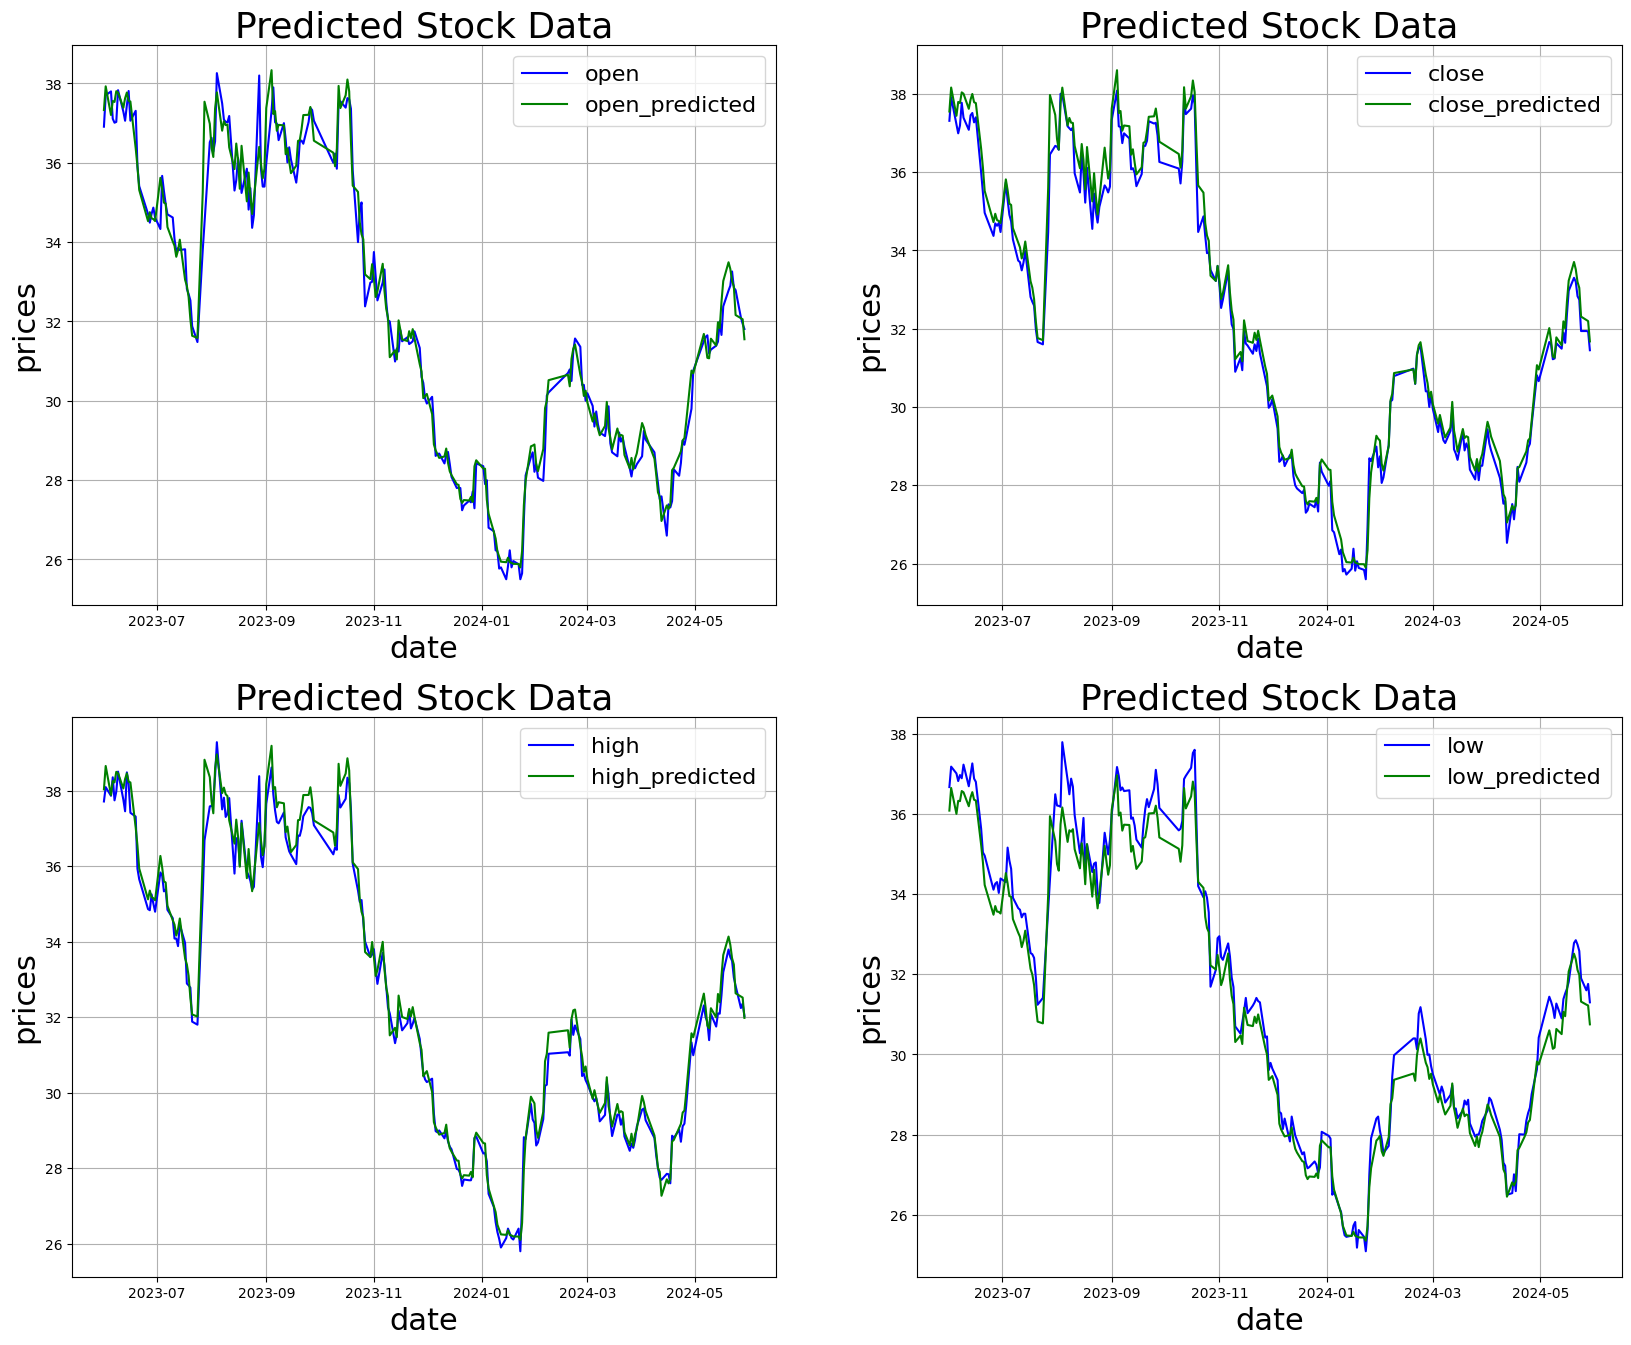

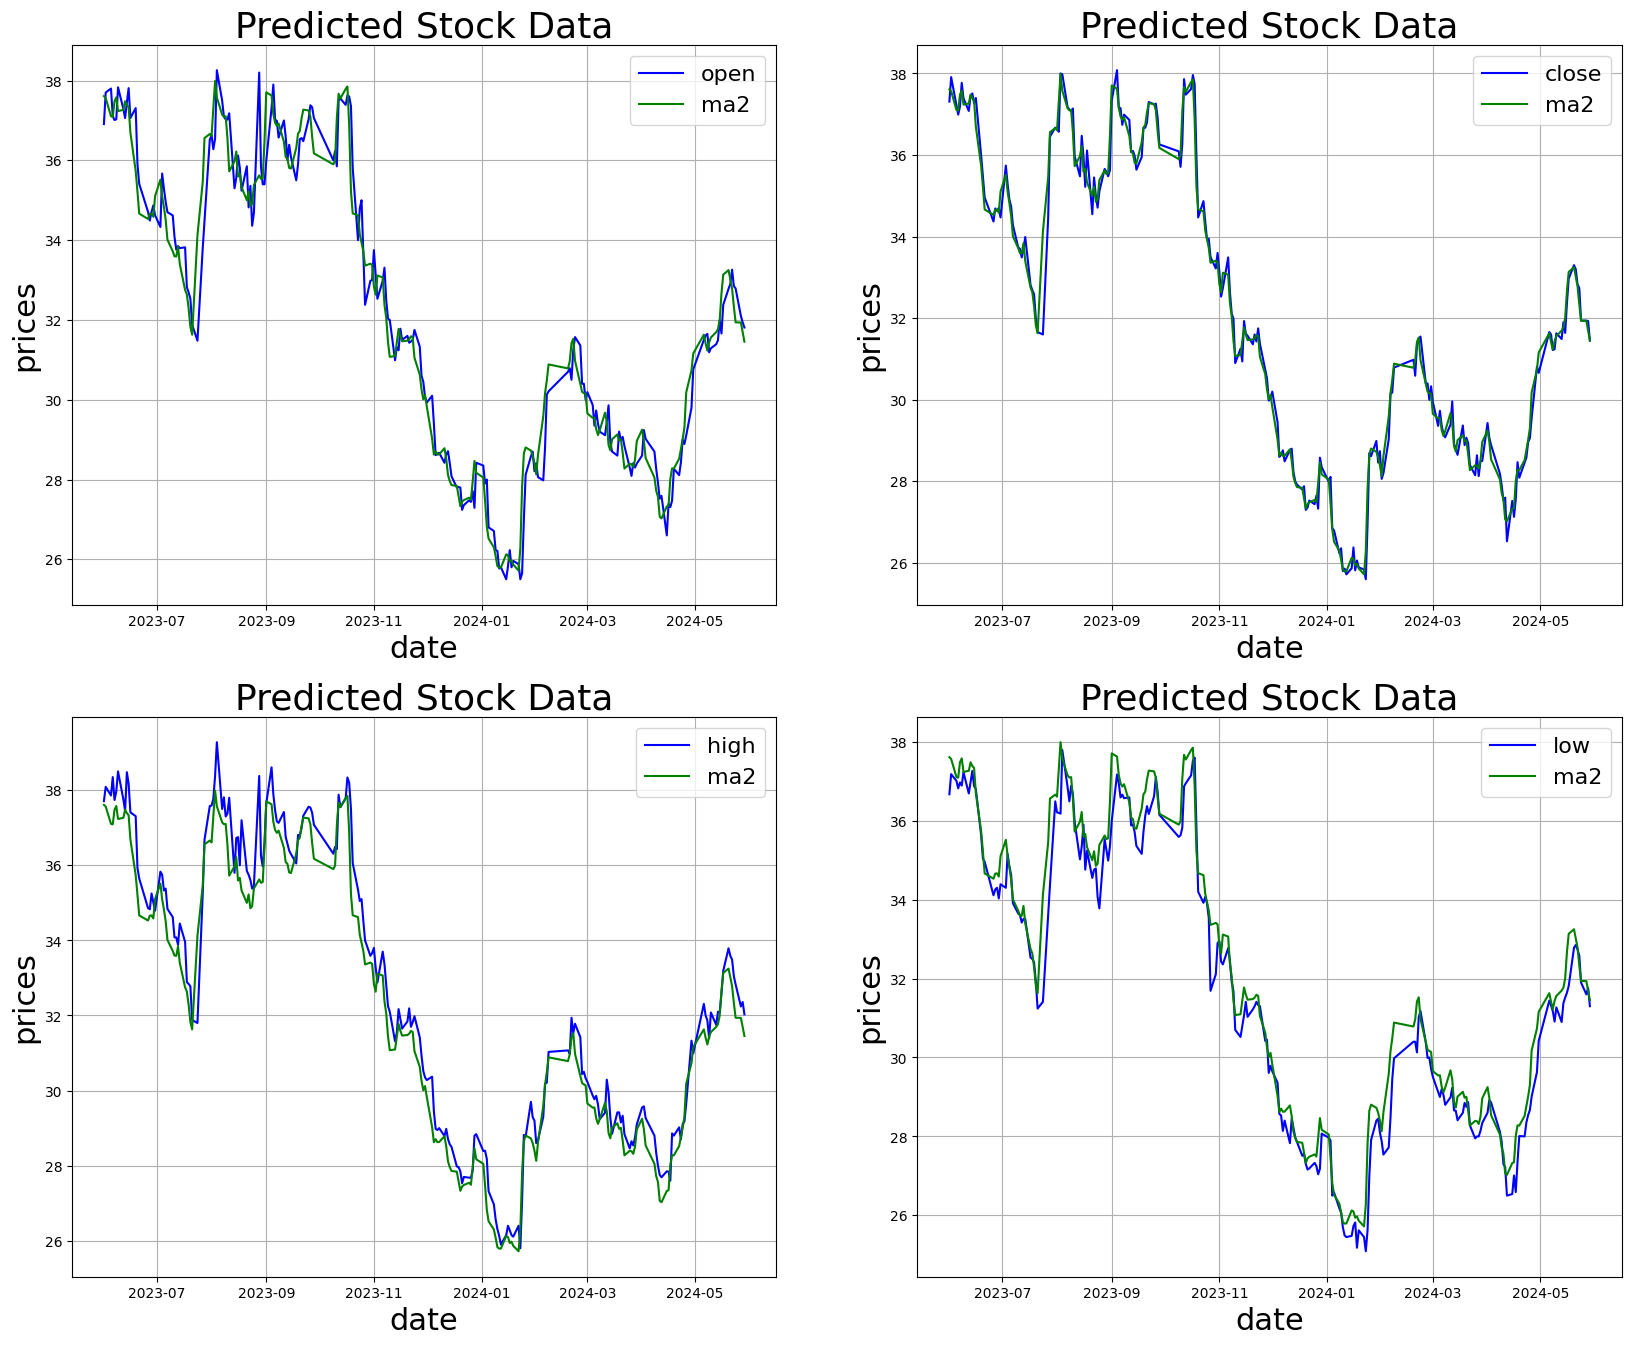

In [3]:
# 交易的股票：
share_list=['002304','600111','000858','601318','000568','300033','601601','600436','601628']

for code in share_list:
    main_script(code)